<a href="https://colab.research.google.com/github/BogdanT54/Economic-Cycles-and-Market-Returns/blob/main/Macroeconomic_Indicator_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalează pachetele necesare (rulat o singură dată)
!pip3 install yfinance statsmodels arch seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.5 MB/s eta 0:00:00


In [ ]:
# Importuri
from datetime import timedelta
import yfinance as yf
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import statsmodels.tsa.stattools as ts
from google.colab import files
from arch.unitroot import ADF, PhillipsPerron, KPSS
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

# **PRELUCRARE DATE**

In [ ]:
#Punem fisiere in df-uri - Este daily
vix_daily = yf.download('^VIX', start='2005-01-01', end='2025-12-30', interval='1d')
vix_monthly = yf.download('^VIX', start='2005-01-01', interval='1mo')

#Broad money - m3_monthly lunar
M3_Yearly = pd.read_excel('Broad Money Yearly World (Worldbank).xlsx', index_col=0, parse_dates=True)
M3_Monthly = pd.read_excel('OECD BROAD MONEY MONTHLY.xlsx', index_col=0, parse_dates=True)

#Recession Indicators - Doar Sahm RUle este lunar
Sahm_Rule = pd.read_excel('SAHM RULE RECESSION INDICATOR FRED.xlsx', index_col=0, parse_dates=True)
FRED_Markov = pd.read_excel('FRED RECESSION INDICATOR MARKOV.xlsx', index_col=0, parse_dates=True)

#PMI (Purchasing Manager's Index) - Indice Lunar
PMI = pd.read_excel('pmi tot.xlsx', index_col=0, parse_dates=True)

#Rata Somajului
Unemployment_rate= pd.read_excel('Unemployment rate 15plus monthly OECD.xlsx', index_col=0, parse_dates=True)

#Interest Rates - Indice Lunari
Interest_Rates = pd.read_excel('Interest rate (USA, EUROPA, CHINA).xlsx', index_col=0, parse_dates=True)
Short_term_interest_rate = pd.read_excel('Short term Interest rates.xlsx', index_col=0, parse_dates=True)
Long_term_interest_rate = pd.read_excel('Long Term Interest rates.xlsx', index_col=0, parse_dates=True)

#PIB
PIB_Monthly = pd.read_excel('IMF QUARTERLY GDP WORLD 2012-2024.xlsx', index_col=0, parse_dates=True)
Pib_Yearly = pd.read_excel('GDP WORLD (WorldBank).xlsx', index_col=0, parse_dates=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Ne asigurăm că toate indexurile sunt unice și datetime
def prepare_df(df):
    df = df.copy()
    df.index = pd.to_datetime(df.index, errors='coerce')
    df = df[~df.index.duplicated(keep='first')]  # eliminăm duplicatele
    return df

# Aplicăm funcția pe fiecare serie lunară
vix_monthly = prepare_df(vix_monthly)
M3_Monthly = prepare_df(M3_Monthly)
Sahm_Rule = prepare_df(Sahm_Rule)
PMI = prepare_df(PMI)
Unemployment_rate = prepare_df(Unemployment_rate)
Interest_Rates = prepare_df(Interest_Rates)
Short_term_interest_rate = prepare_df(Short_term_interest_rate)
Long_term_interest_rate = prepare_df(Long_term_interest_rate)
PIB_Monthly = prepare_df(PIB_Monthly)

# La fel și pentru anuale
M3_Yearly = prepare_df(M3_Yearly)
Pib_Yearly = prepare_df(Pib_Yearly)
FRED_Markov = prepare_df(FRED_Markov)

# --- Lunar ---
data_monthly = pd.concat([
    vix_monthly['Close'],
    M3_Monthly,
    Sahm_Rule,
    PMI,
    Unemployment_rate,
    Interest_Rates,
    PIB_Monthly[['GDP CONSTANT PRICES']]
], axis=1)

# --- Anual ---
data_yearly = pd.concat([
    M3_Yearly,
    Pib_Yearly,
], axis=1)

# === 5. Opțional: sortare cronologică și completări lipsă ===
data_monthly = data_monthly.sort_index().ffill().bfill()
data_yearly = data_yearly.sort_index().ffill().bfill()

# === 6. Verificare dimensiuni ===
print("Dimensiuni date lunare:", data_monthly.shape)
print("Dimensiuni date anuale:", data_yearly.shape)

Dimensiuni date lunare: (247, 15)
Dimensiuni date anuale: (19, 2)


In [ ]:
data_monthly.head(20)

,^VIX,Broad Money (% of GDP),Sahm_Rule,Global PMI,US PMI,Eurozone PMI,Japan PMI,Rata Somajului,United States - Long Term,Euro area - Long Term,China - Long Term,United States - Short Term,Euro area - Short Term,China - Short Term,GDP CONSTANT PRICES
2005-01-01,12.820000,39.51634,-0.10,54.4,56.8,51.9,53.0,6.928234,4.22,3.6336,4.5019,2.61,2.1454,2.49,25206.1676
2005-02-01,12.080000,39.76384,0.00,54.4,55.9,51.9,53.0,6.951199,4.17,3.6153,4.5019,2.77,2.1383,2.38,25206.1676
2005-03-01,14.020000,40.18619,-0.07,54.4,55.2,50.4,53.0,6.902696,4.50,3.7625,4.5019,2.97,2.1372,2.51,25206.1676
2005-04-01,15.310000,40.77878,0.00,54.4,52.2,49.2,53.0,6.926709,4.34,3.5709,4.5019,3.09,2.1372,2.21,25206.1676
2005-05-01,13.290000,41.34454,-0.10,54.4,50.8,48.7,53.0,6.907186,4.14,3.4074,4.5019,3.22,2.1256,1.52,25206.1676
2005-06-01,12.040000,41.92598,-0.07,54.4,52.4,49.9,53.0,6.864010,4.00,3.2541,4.5019,3.38,2.1110,1.50,25206.1676
2005-07-01,11.570000,42.48307,-0.07,54.4,52.8,50.8,53.0,6.818183,4.18,3.3160,4.5019,3.57,2.1194,1.54,25206.1676
2005-08-01,12.600000,42.86208,-0.07,54.4,52.4,50.4,53.0,6.736215,4.26,3.3155,4.5019,3.77,2.1325,1.49,25206.1676
2005-09-01,11.920000,43.31301,0.03,54.4,56.8,51.7,53.0,6.784588,4.20,3.1555,4.5019,3.87,2.1391,1.52,25206.1676
2005-10-01,15.320000,43.89588,0.03,54.4,57.2,52.7,53.0,6.789459,4.46,3.3234,4.5019,4.13,2.1966,1.83,25206.1676


# **STATISTICI TOATE**

In [ ]:
statistics = data_monthly.describe()

# adaugam explicit linia 'median'
statistics.loc['median'] = data_monthly.median()

# ordonam liniile ca sa apara median dupa mean
statistics = statistics.reindex(['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max'])

statistics.head(20)

,^VIX,Broad Money (% of GDP),Sahm_Rule,Global PMI,US PMI,Eurozone PMI,Japan PMI,Rata Somajului,United States - Long Term,Euro area - Long Term,China - Long Term,United States - Short Term,Euro area - Short Term,China - Short Term,GDP CONSTANT PRICES
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000
mean,19.508462,99.293647,0.503441,52.225101,52.737652,51.072065,50.345344,6.556513,2.968462,2.567637,3.733026,2.028623,1.282898,3.401781,29215.392193
median,17.950001,98.702710,0.000000,52.400000,52.800000,51.700000,50.800000,6.438266,2.830000,3.171200,3.740000,1.070000,0.645000,3.110000,28114.006970
std,8.021822,32.197488,1.379943,2.404234,5.020907,5.415342,3.727688,1.225948,1.153271,1.450972,0.763546,2.039565,1.775323,1.166141,4181.456737
min,9.510000,39.516340,-0.370000,39.600000,33.100000,33.400000,29.600000,4.759399,0.620000,-0.091500,2.538000,0.090000,-0.582000,1.090000,25206.167600
25%,13.975000,74.399480,-0.070000,50.400000,49.750000,47.550000,49.000000,5.482740,2.045000,1.195950,2.900000,0.235000,-0.309850,2.730000,25206.167600
50%,17.950001,98.702710,0.000000,52.400000,52.800000,51.700000,50.800000,6.438266,2.830000,3.171200,3.740000,1.070000,0.645000,3.110000,28114.006970
75%,22.625000,135.339100,0.270000,54.400000,56.450000,54.950000,52.800000,7.715478,3.990000,3.803850,4.501900,3.860000,2.758200,4.255000,32449.633120
max,59.889999,135.339100,9.500000,57.800000,64.700000,63.400000,56.600000,8.836058,5.110000,4.814500,4.501900,5.490000,5.113100,6.960000,37573.745930


In [ ]:
from sklearn.preprocessing import StandardScaler

# 1. Eliminăm rândurile cu NaN pentru a putea standardiza corect
data_monthly_clean = data_monthly.dropna()

# 2. Aplicăm standardizarea Z-score pe toate coloanele
scaler = StandardScaler()
data_monthly_std = pd.DataFrame(
    scaler.fit_transform(data_monthly_clean),
    columns=data_monthly_clean.columns,
    index=data_monthly_clean.index
)

# 3. Verificare rapidă
print(data_monthly_std.describe().T[['mean', 'std']])
data_monthly_std.head(-20)

                                    mean      std
^VIX                        1.726015e-16  1.00203
Broad Money (% of GDP)      1.495879e-15  1.00203
Sahm_Rule                   4.494830e-18  1.00203
Global PMI                 -3.078060e-15  1.00203
US PMI                     -4.027368e-16  1.00203
Eurozone PMI                7.982818e-16  1.00203
Japan PMI                   5.196024e-16  1.00203
Rata Somajului             -6.904059e-16  1.00203
United States - Long Term   4.027368e-16  1.00203
Euro area - Long Term      -5.753382e-17  1.00203
China - Long Term           3.452029e-16  1.00203
United States - Short Term -4.315037e-17  1.00203
Euro area - Short Term     -2.876691e-17  1.00203
China - Short Term          7.191728e-17  1.00203
GDP CONSTANT PRICES        -1.438346e-15  1.00203


,^VIX,Broad Money (% of GDP),Sahm_Rule,Global PMI,US PMI,Eurozone PMI,Japan PMI,Rata Somajului,United States - Long Term,Euro area - Long Term,China - Long Term,United States - Short Term,Euro area - Short Term,China - Short Term,GDP CONSTANT PRICES
2005-01-01,-0.831718,-1.860353,-0.438182,0.906449,0.810729,0.153197,0.713591,0.303827,1.087411,0.736146,1.009022,0.285628,0.486815,-0.783467,-0.960757
2005-02-01,-0.924135,-1.852650,-0.365568,0.906449,0.631115,0.153197,0.713591,0.322597,1.043968,0.723508,1.009022,0.364235,0.482807,-0.877986,-0.960757
2005-03-01,-0.681853,-1.839506,-0.416398,0.906449,0.491415,-0.124356,0.713591,0.282953,1.330692,0.825163,1.009022,0.462495,0.482186,-0.766281,-0.960757
2005-04-01,-0.520747,-1.821064,-0.365568,0.906449,-0.107300,-0.346398,0.713591,0.302580,1.191674,0.692846,1.009022,0.521450,0.482186,-1.024062,-0.960757
2005-05-01,-0.773021,-1.803457,-0.438182,0.906449,-0.386700,-0.438916,0.713591,0.286623,1.017902,0.579934,1.009022,0.585319,0.475639,-1.616959,-0.960757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,-0.191043,1.121784,-0.292954,-1.510860,-1.264815,-1.549129,-0.200354,-1.408372,0.809376,0.484218,-1.408172,1.631780,1.348348,-0.714725,1.653268
2023-08-01,-0.191043,1.121784,-0.271170,-1.344149,-1.025329,-1.401101,-0.200354,-1.408937,1.043968,0.535598,-1.539406,1.675996,1.409587,-0.663169,1.653268
2023-09-01,-0.191043,1.121784,-0.220341,-1.260794,-0.745929,-1.419604,-0.496042,-1.398727,1.226428,0.647750,-1.381925,1.700561,1.465860,-0.654576,1.653268
2023-10-01,-0.191043,1.121784,-0.125942,-1.427505,-1.204944,-1.475115,-0.442281,-1.373930,1.591349,0.795813,-1.368802,1.685822,1.516658,-0.577242,1.706792


# **INDICE VIX**

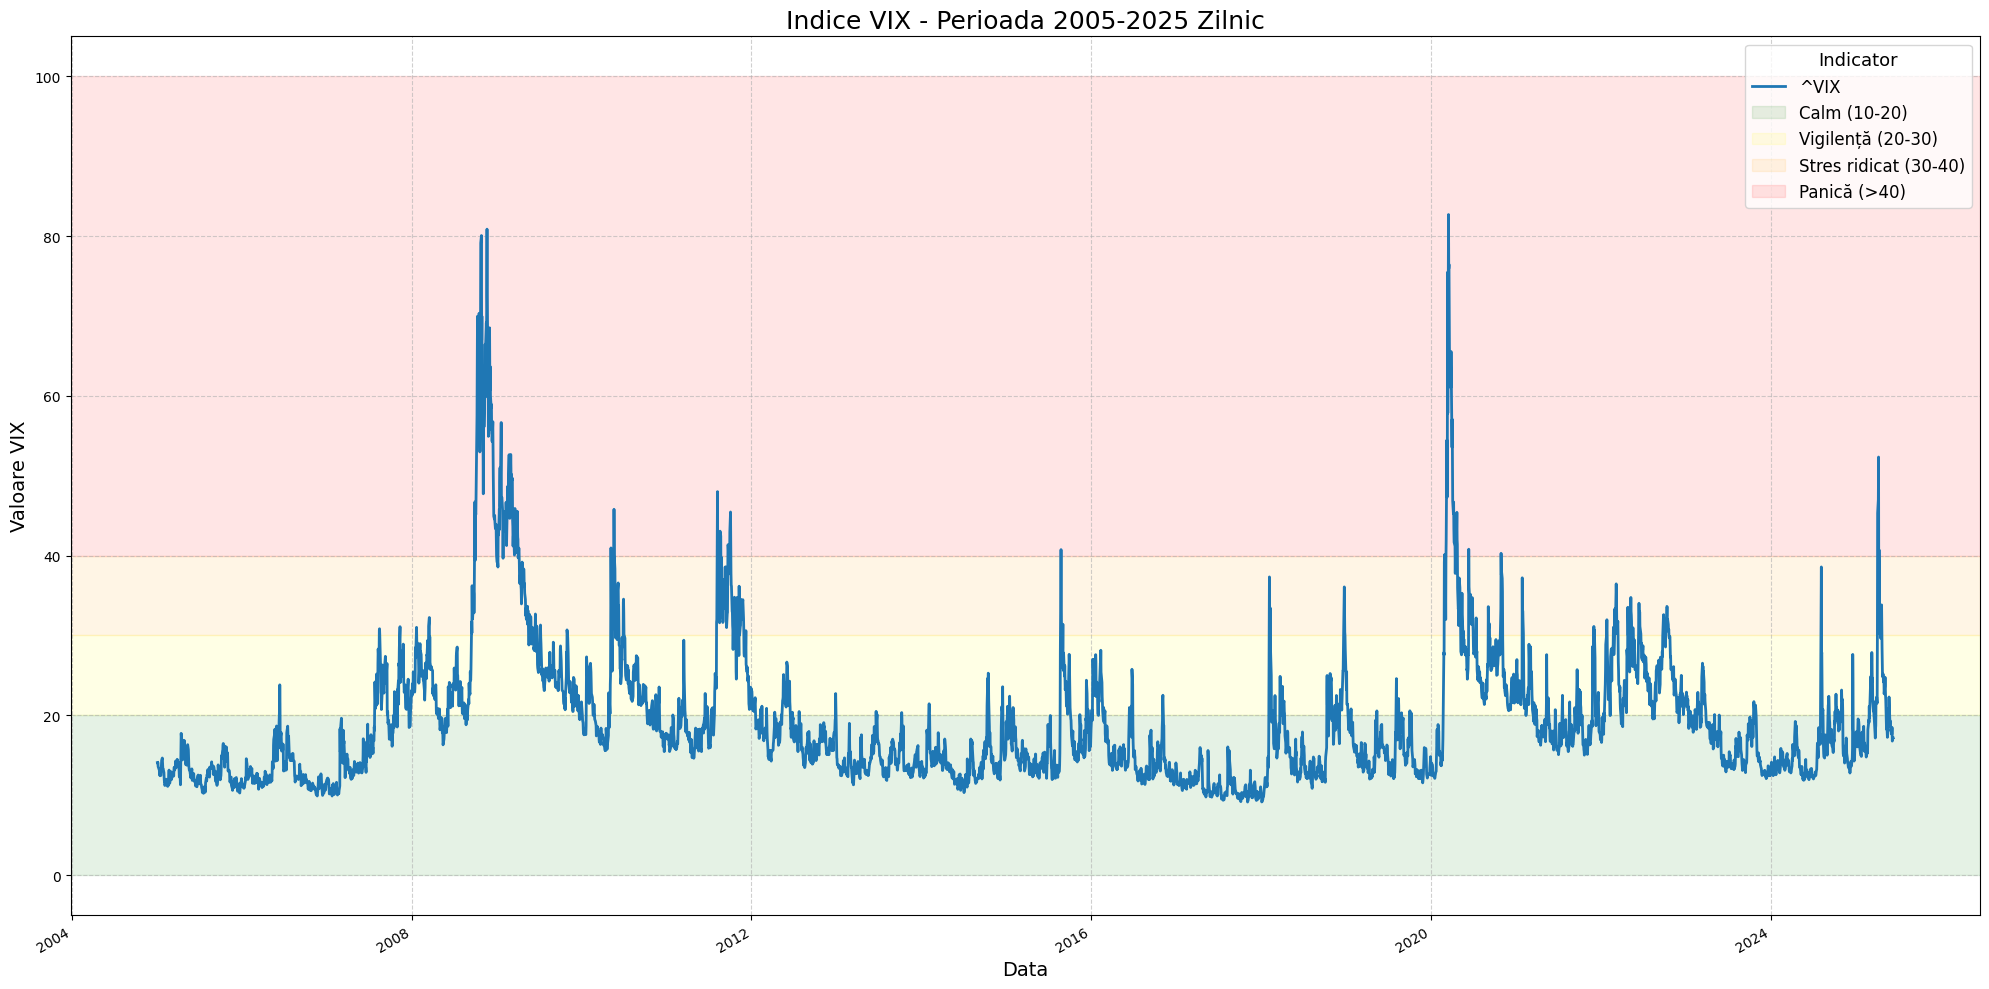

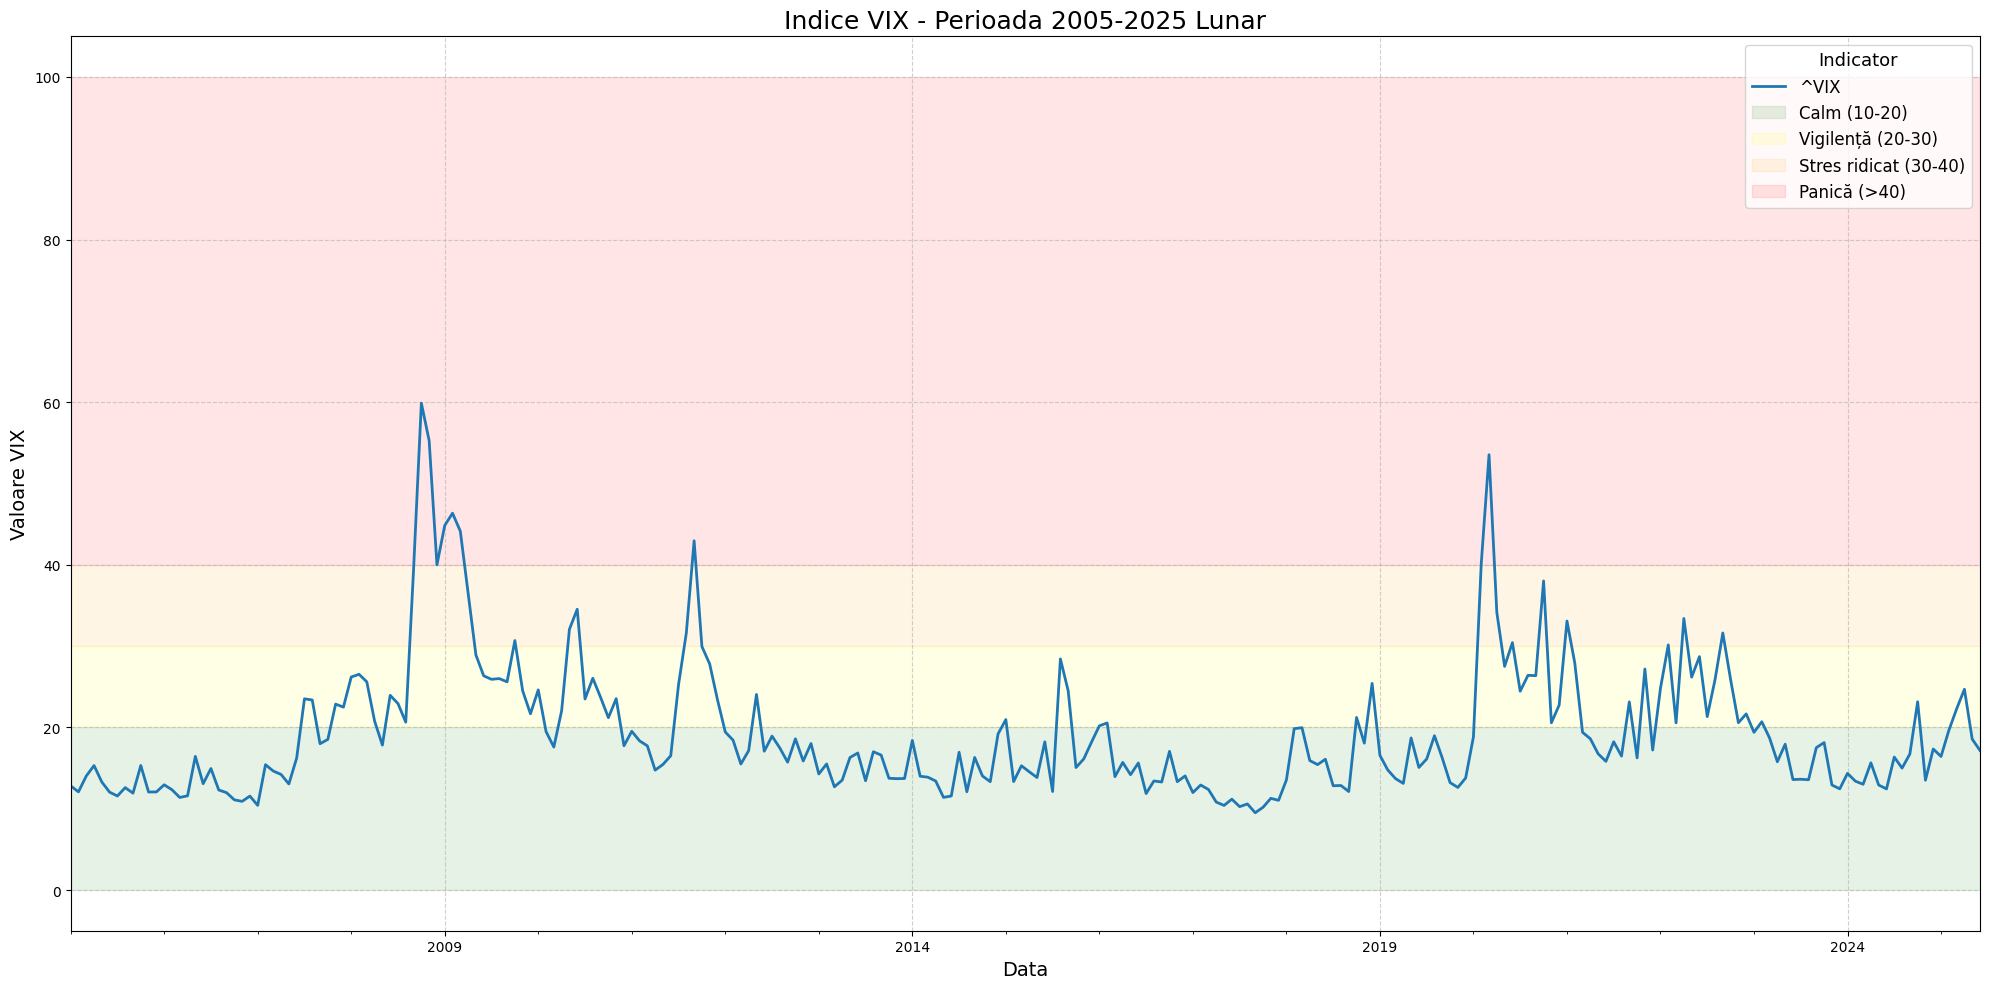

In [ ]:
#VIX daily

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
ax = plt.gca()
vix_daily['Close'].plot(ax=ax, linewidth=2)
ax.set_title('Indice VIX - Perioada 2005-2025 Zilnic', fontsize=18)
ax.set_ylabel("Valoare VIX", fontsize=14)
ax.set_xlabel("Data", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title="Indicator", fontsize=12, title_fontsize=13)
ax.axhspan(0, 20, color='green', alpha=0.10, label='Calm (10-20)')
ax.axhspan(20, 30, color='yellow', alpha=0.10, label='Vigilență (20-30)')
ax.axhspan(30, 40, color='orange', alpha=0.10, label='Stres ridicat (30-40)')
ax.axhspan(40, 100, color='red', alpha=0.10, label='Panică (>40)')
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Indicator", fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()


#VIX monthly
vix_monthly =  vix_daily.resample('M').last()
plt.figure(figsize=(20, 10))
ax = plt.gca()
vix_monthly['Close'].plot(ax=ax, linewidth=2)
ax.set_title('Indice VIX - Perioada 2005-2025 Lunar', fontsize=18)
ax.set_ylabel("Valoare VIX", fontsize=14)
ax.set_xlabel("Data", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title="Indicator", fontsize=12, title_fontsize=13)
ax.axhspan(0, 20, color='green', alpha=0.10, label='Calm (10-20)')
ax.axhspan(20, 30, color='yellow', alpha=0.10, label='Vigilență (20-30)')
ax.axhspan(30, 40, color='orange', alpha=0.10, label='Stres ridicat (30-40)')
ax.axhspan(40, 100, color='red', alpha=0.10, label='Panică (>40)')
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Indicator", fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()

In [ ]:
def calculeaza_momente(serie):
    serie = serie.dropna()

    mean_val = serie.mean().item()
    std_val = serie.std().item()
    var_val = serie.var().item()
    skew_val = skew(serie, bias=False).item()
    kurt_val = kurtosis(serie, bias=False).item()  # kurt standard
    cv_val = (std_val / abs(mean_val))

    rezultate = {
        'N': len(serie),
        'Mean': mean_val,
        'Mediana': serie.median().item(),
        'Std Deviation': std_val,
        'Variance': var_val,
        'Skewness': skew_val,
        'Kurtosis': kurt_val,
        'Coeff Variation': cv_val,
        'Min': serie.min().item(),
        'Max': serie.max().item(),
        '25%': serie.quantile(0.25).item(),
        '50%': serie.quantile(0.5).item(),
        '75%': serie.quantile(0.75).item(),
        '90%': serie.quantile(0.9).item(),
        '95%': serie.quantile(0.95).item(),
        '99%': serie.quantile(0.99).item(),
    }

    return pd.DataFrame(rezultate, index=[0])


calculeaza_momente(vix_daily['Close'])

,N,Mean,Mediana,Std Deviation,Variance,Skewness,Kurtosis,Coeff Variation,Min,Max,25%,50%,75%,90%,95%,99%
0,5142,19.203036,16.775001,8.751241,76.584226,2.505381,9.319224,0.455722,9.14,82.690002,13.3925,16.775001,22.280001,28.706999,34.724,55.759499


# **PRODUS INTERN BRUT**

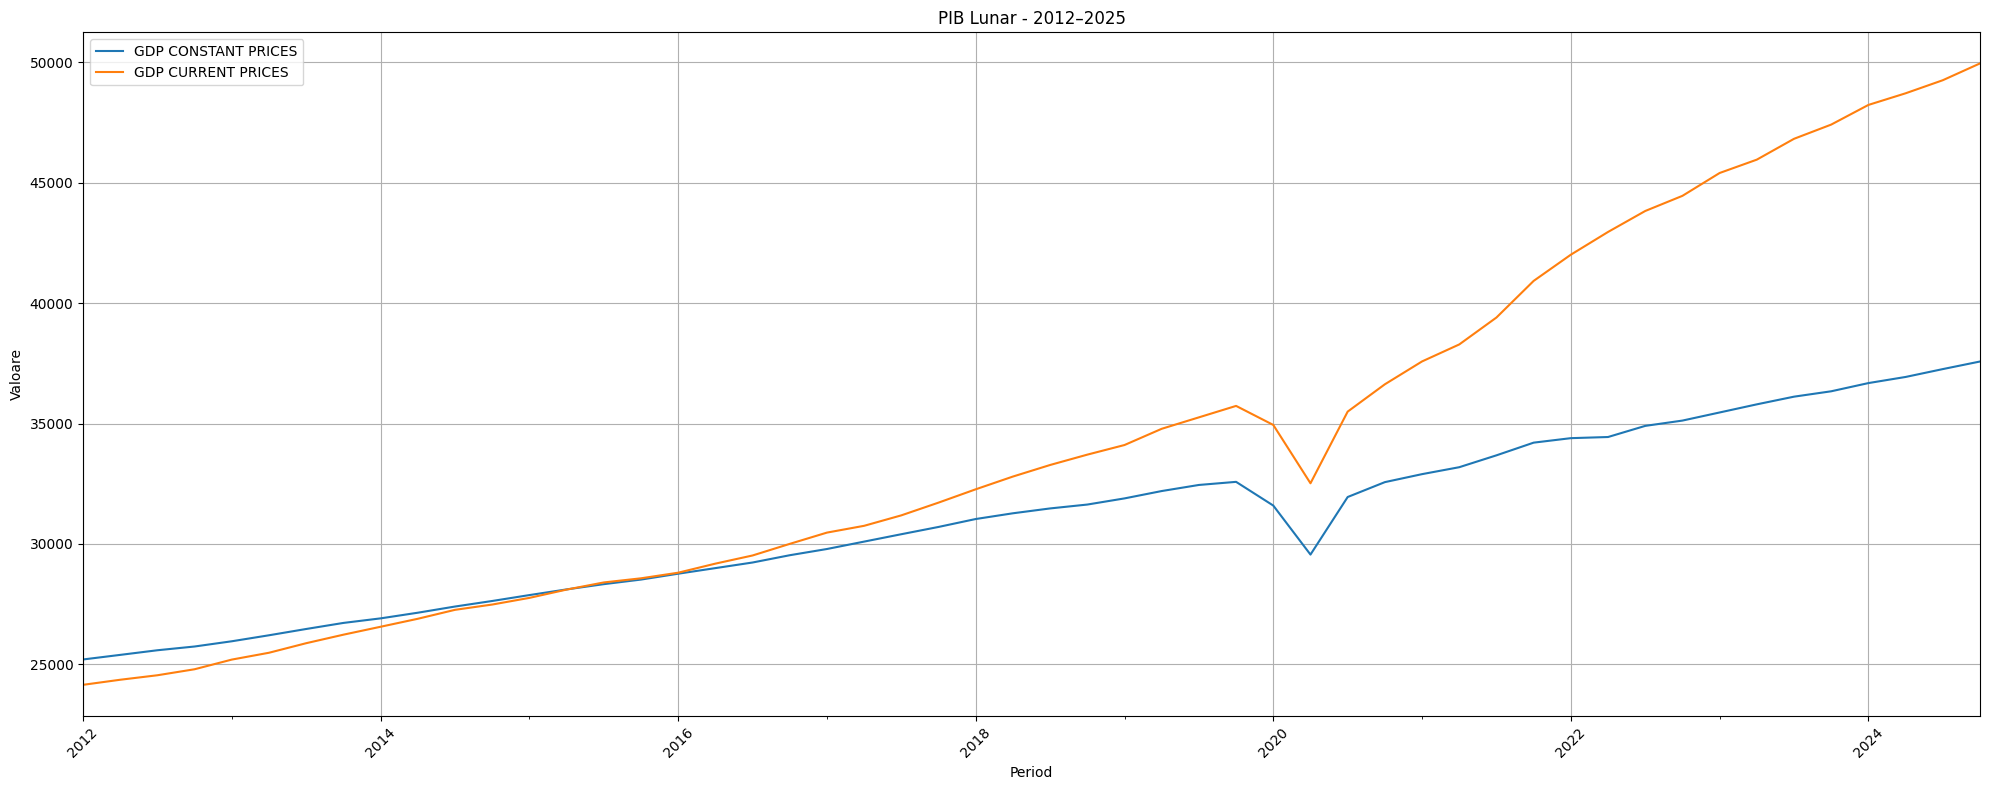

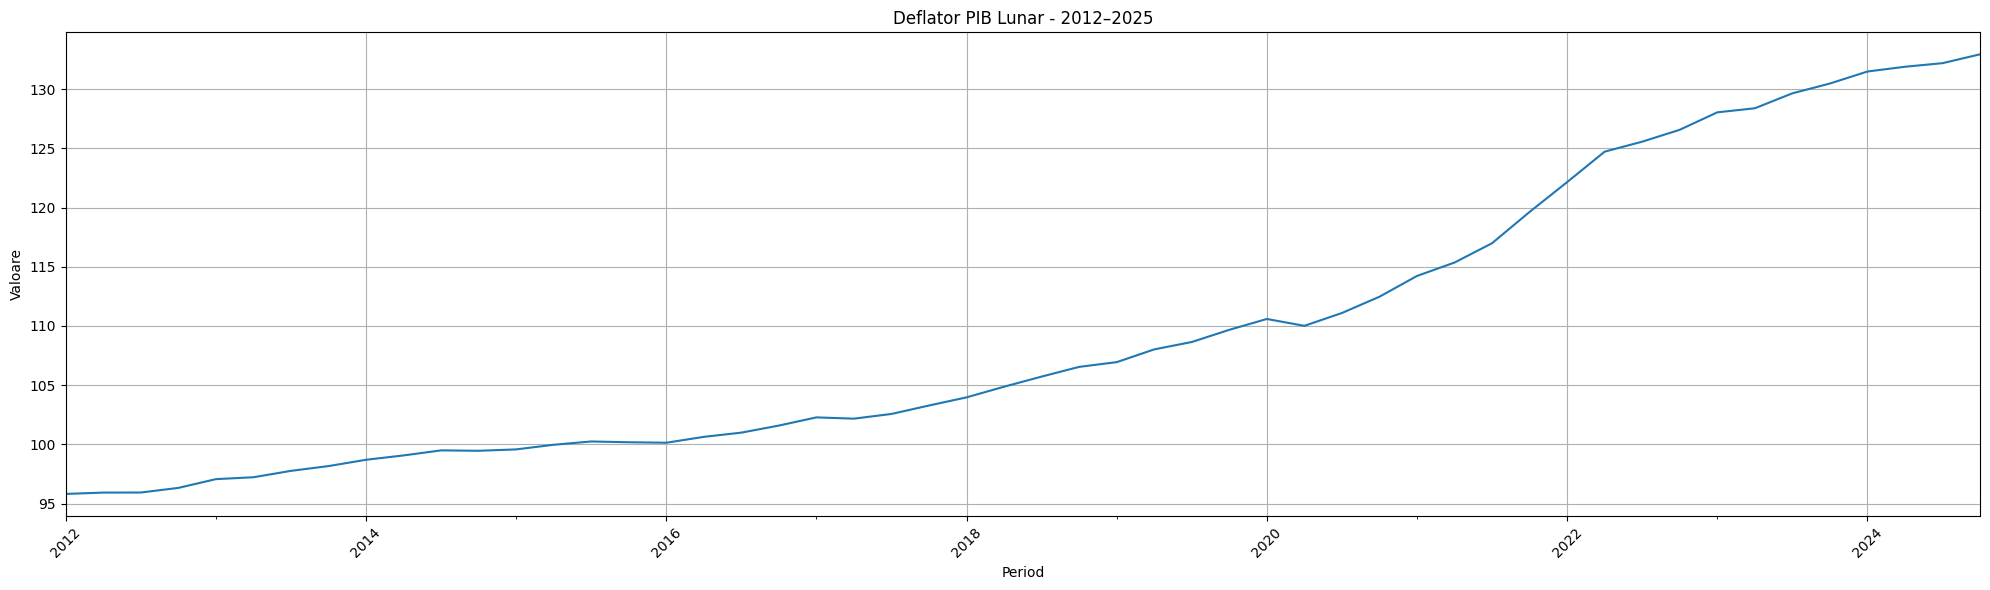

In [ ]:
#PIB Lunar - International Monetary Fund, World
fig, ax = plt.subplots(figsize=(20, 8))
PIB_Monthly[['GDP CONSTANT PRICES', 'GDP CURRENT PRICES']].plot(ax=ax, title='PIB Lunar - 2012–2025')
ax.set_ylabel("Valoare")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
plt.show()


#Deflator PIB
fig, ax = plt.subplots(figsize=(20, 6))
PIB_Monthly['GDP Price Deflator'].plot(ax=ax, title='Deflator PIB Lunar - 2012–2025', legend=False)
ax.set_ylabel("Valoare")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
plt.show()

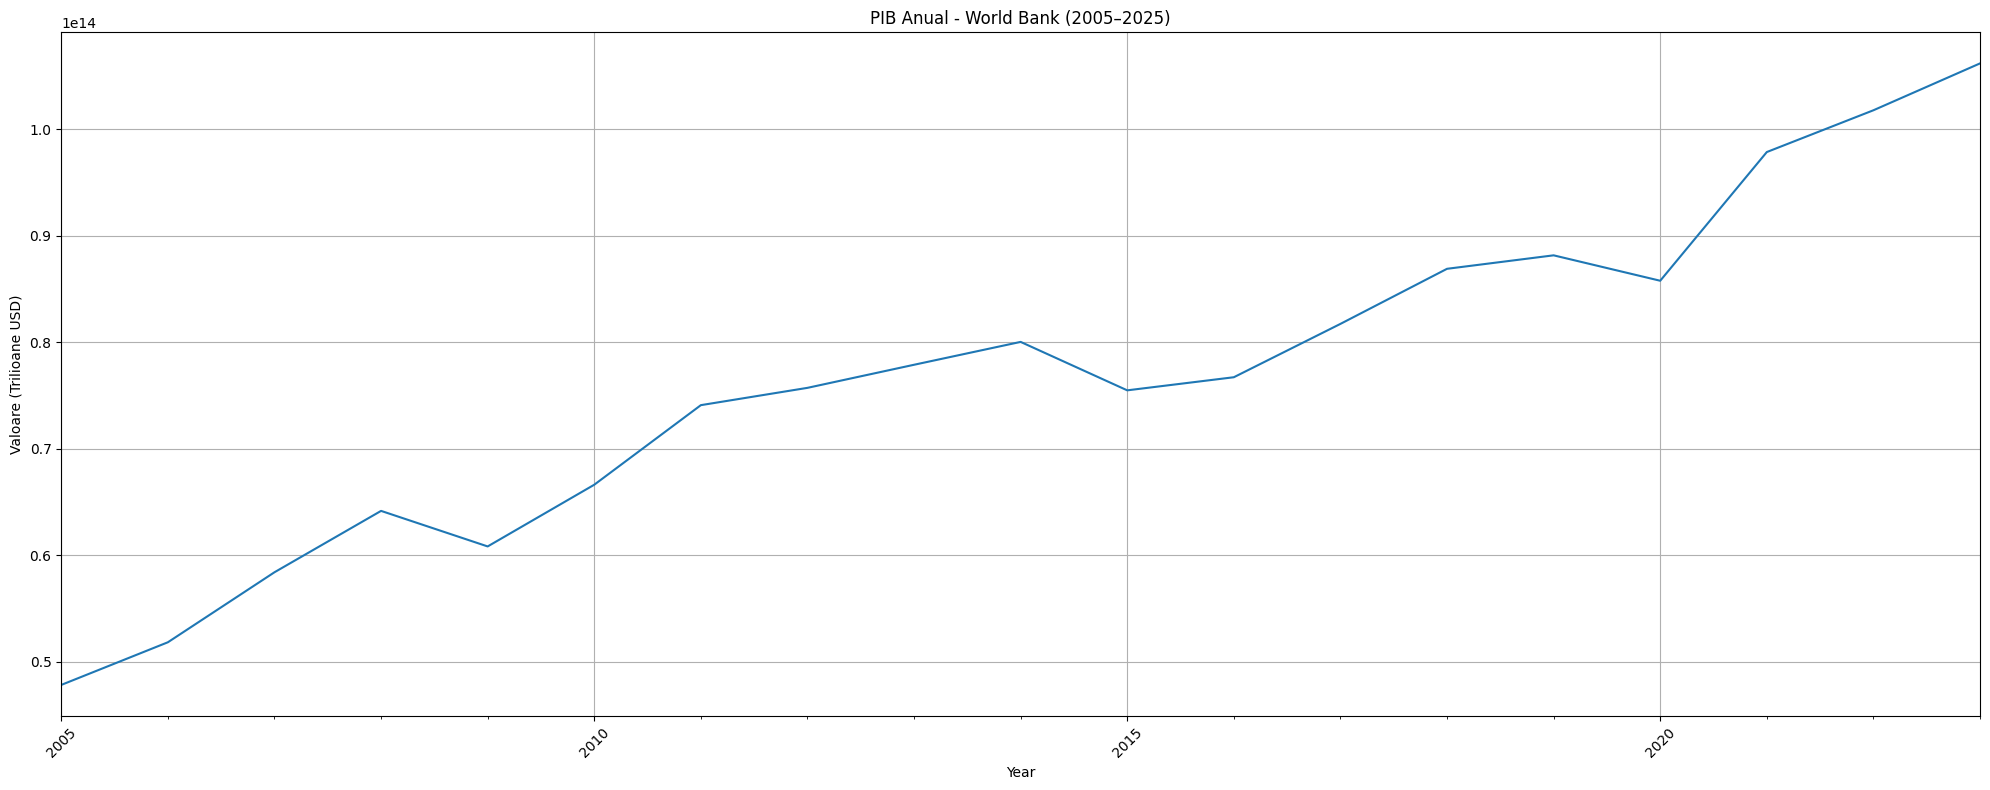

In [ ]:
#PIB Anual - World Bank, World => Exprimat in Trilioane $
fig, ax = plt.subplots(figsize=(20, 8))
Pib_Yearly.plot(ax=ax, title='PIB Anual - World Bank (2005–2025)', legend=False)
ax.set_ylabel("Valoare (Trilioane USD)")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
plt.show()

In [ ]:
PIB_Monthly['GDP CONSTANT PRICES'].describe()

,GDP CONSTANT PRICES
count,52.000000
mean,30999.151101
std,3584.284893
min,25206.167600
25%,28055.153113
50%,31154.868195
75%,33810.915335
max,37573.745930


In [ ]:
PIB_Monthly['GDP Price Deflator'].describe()

,GDP Price Deflator
count,52.000000
mean,109.489625
std,12.064962
min,95.824565
25%,99.875670
50%,105.302040
75%,117.646133
max,132.930580


In [ ]:
calculeaza_momente(Pib_Yearly)

,N,Mean,Mediana,Std Deviation,Variance,Skewness,Kurtosis,Coeff Variation,Min,Max,25%,50%,75%,90%,95%,99%
0,19,7.672362e+13,7.670255e+13,1.600154e+13,2.560494e+26,0.019172,-0.405482,0.208561,4.781168e+13,1.061717e+14,6.538099e+13,7.670255e+13,8.632393e+13,9.863282e+13,1.022110e+14,1.053795e+14


# **Rata dobanzilor**

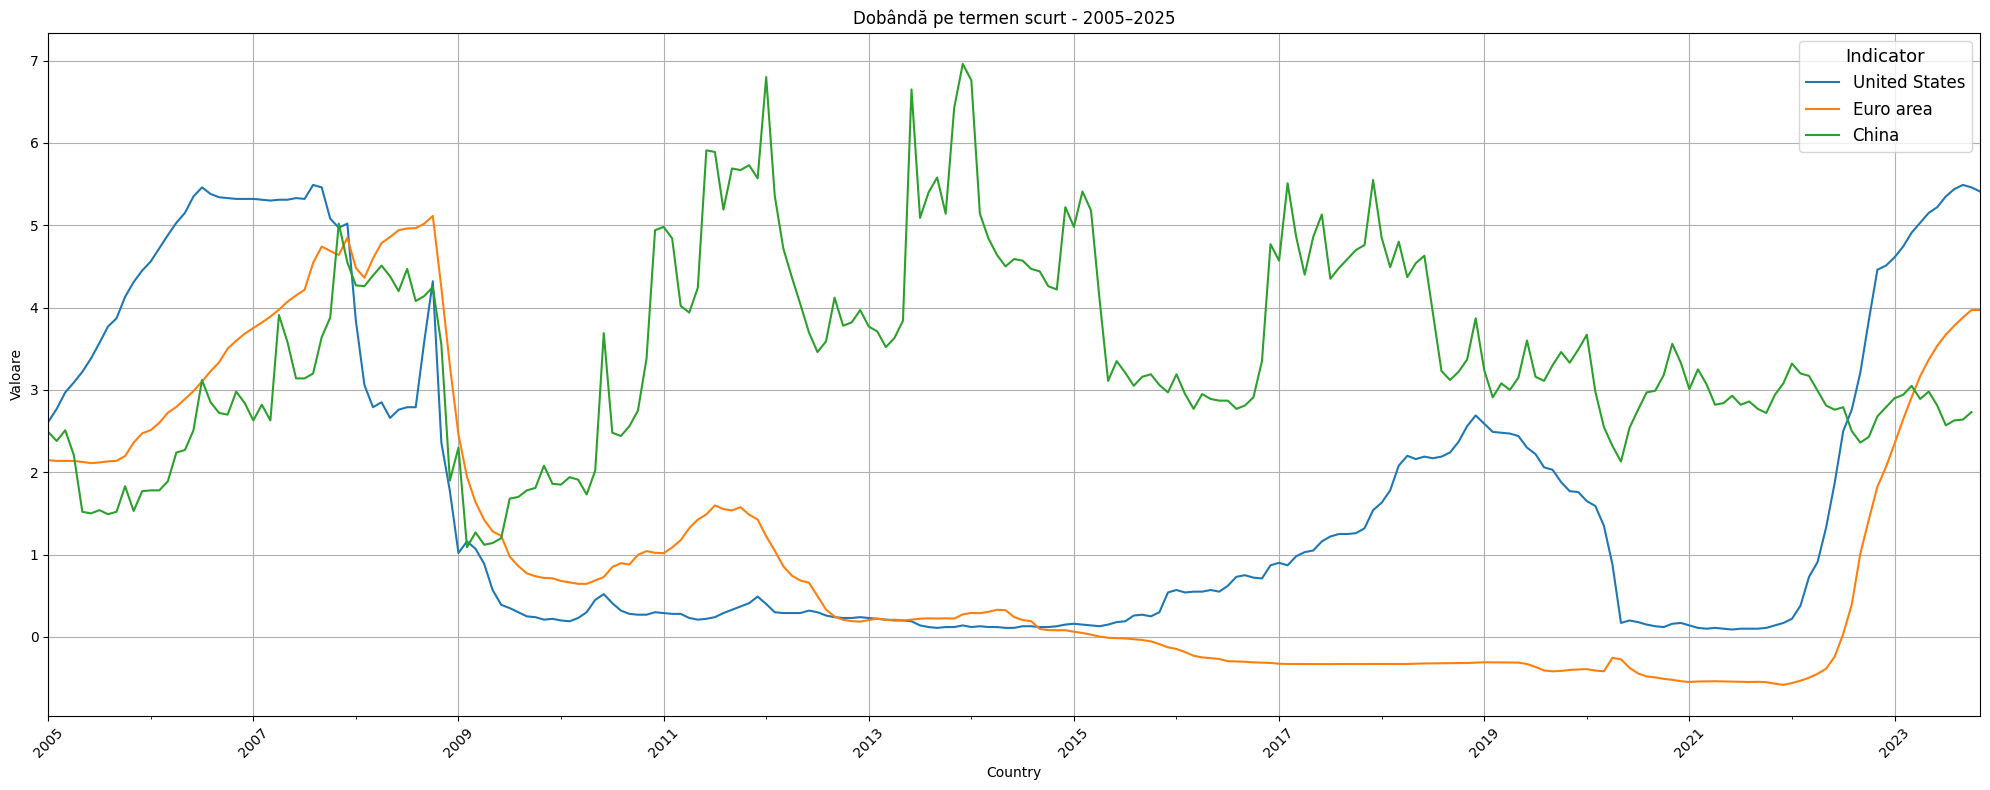

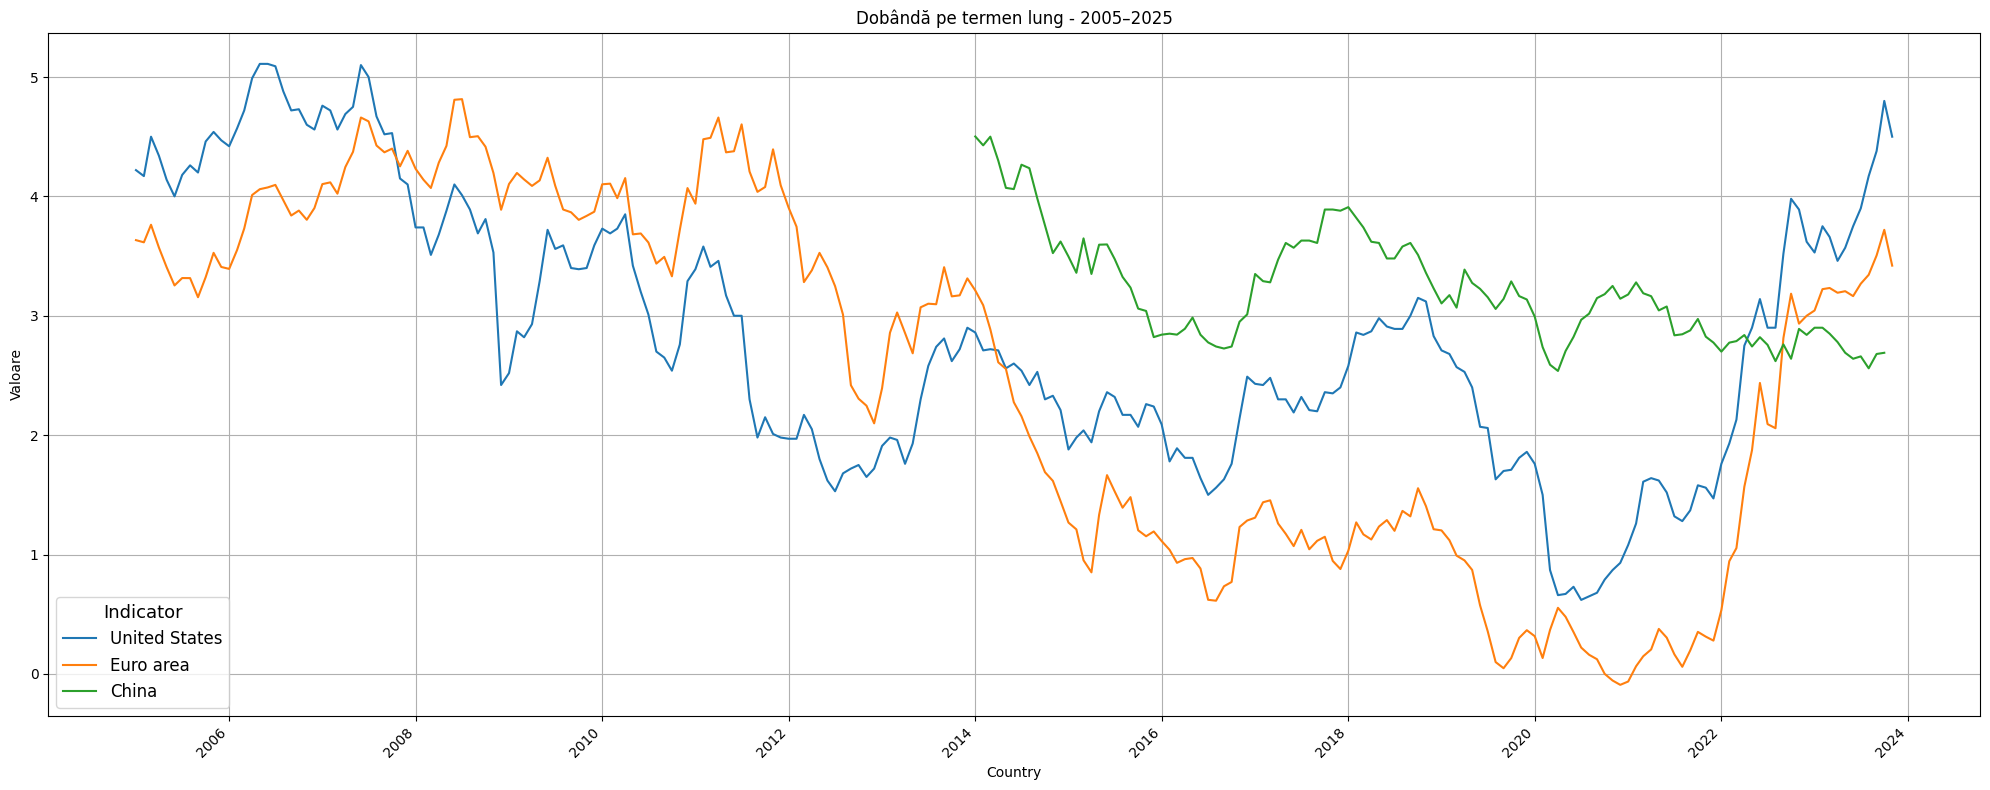

In [ ]:
#Interest Rates

#Short-term
fig, ax = plt.subplots(figsize=(20, 8))
Short_term_interest_rate.plot(ax=ax, title='Dobândă pe termen scurt - 2005–2025')
ax.legend(title="Indicator", fontsize=12, title_fontsize=13)
ax.set_ylabel("Valoare")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
plt.show()


#Long-term
fig, ax = plt.subplots(figsize=(20, 8))
Long_term_interest_rate.plot(ax=ax, title='Dobândă pe termen lung - 2005–2025')
ax.legend(title="Indicator", fontsize=12, title_fontsize=13)
ax.set_ylabel("Valoare")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
plt.show()

In [ ]:
Short_term_interest_rate.describe()

,United States,Euro area,China
count,227.000000,227.000000,226.000000
mean,1.728640,1.046149,3.464204
std,1.851896,1.653907,1.200322
min,0.090000,-0.582000,1.090000
25%,0.225000,-0.316100,2.752500
50%,0.750000,0.273500,3.190000
75%,2.780000,2.129050,4.370000
max,5.490000,5.113100,6.960000


In [ ]:
Long_term_interest_rate.describe()

,United States,Euro area,China
count,227.000000,227.000000,118.000000
mean,2.833524,2.492539,3.214934
std,1.105383,1.490528,0.462742
min,0.620000,-0.091500,2.538000
25%,1.980000,1.137500,2.838950
50%,2.710000,3.009400,3.145550
75%,3.690000,3.876550,3.521175
max,5.110000,4.814500,4.501900


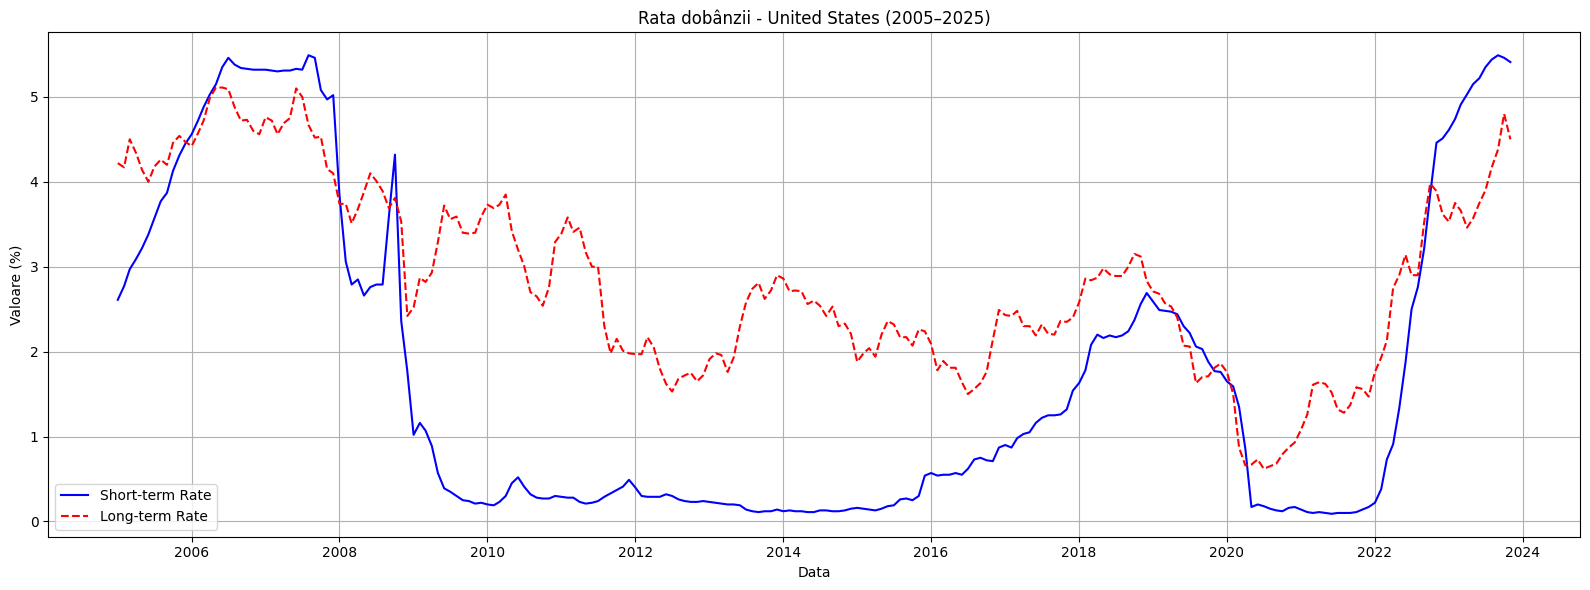

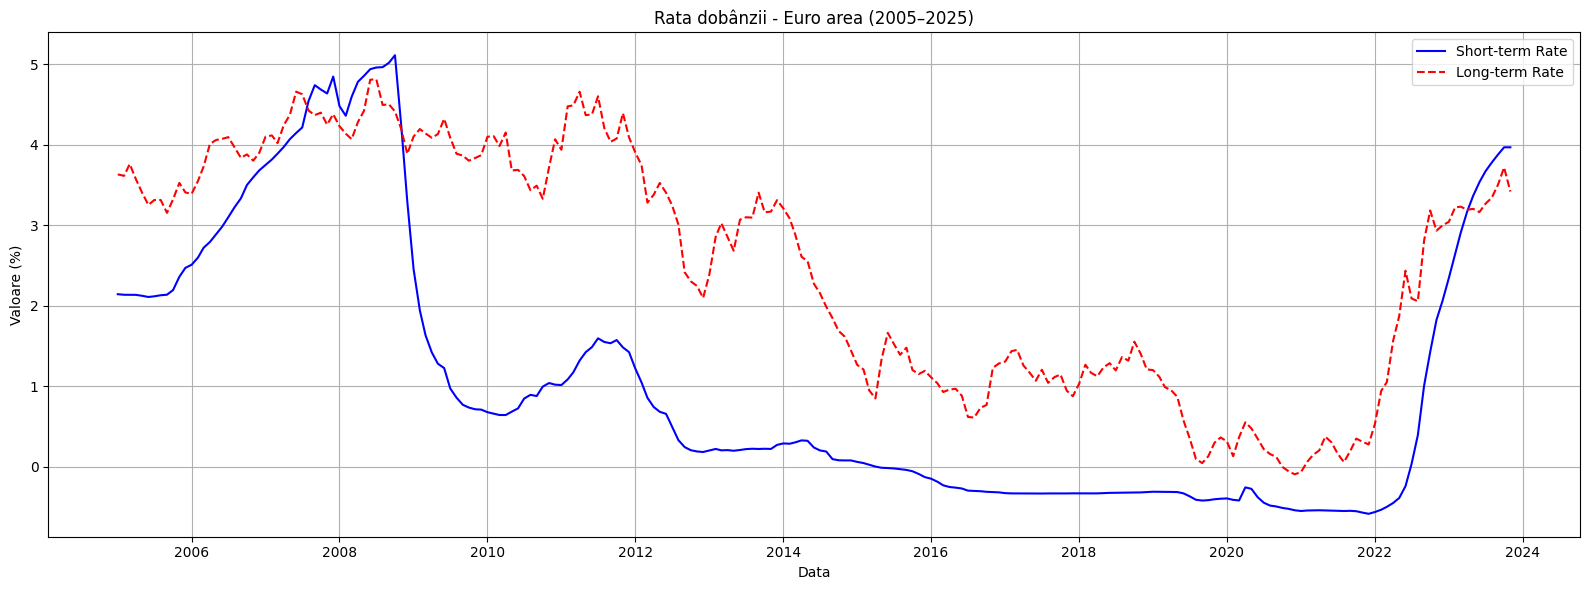

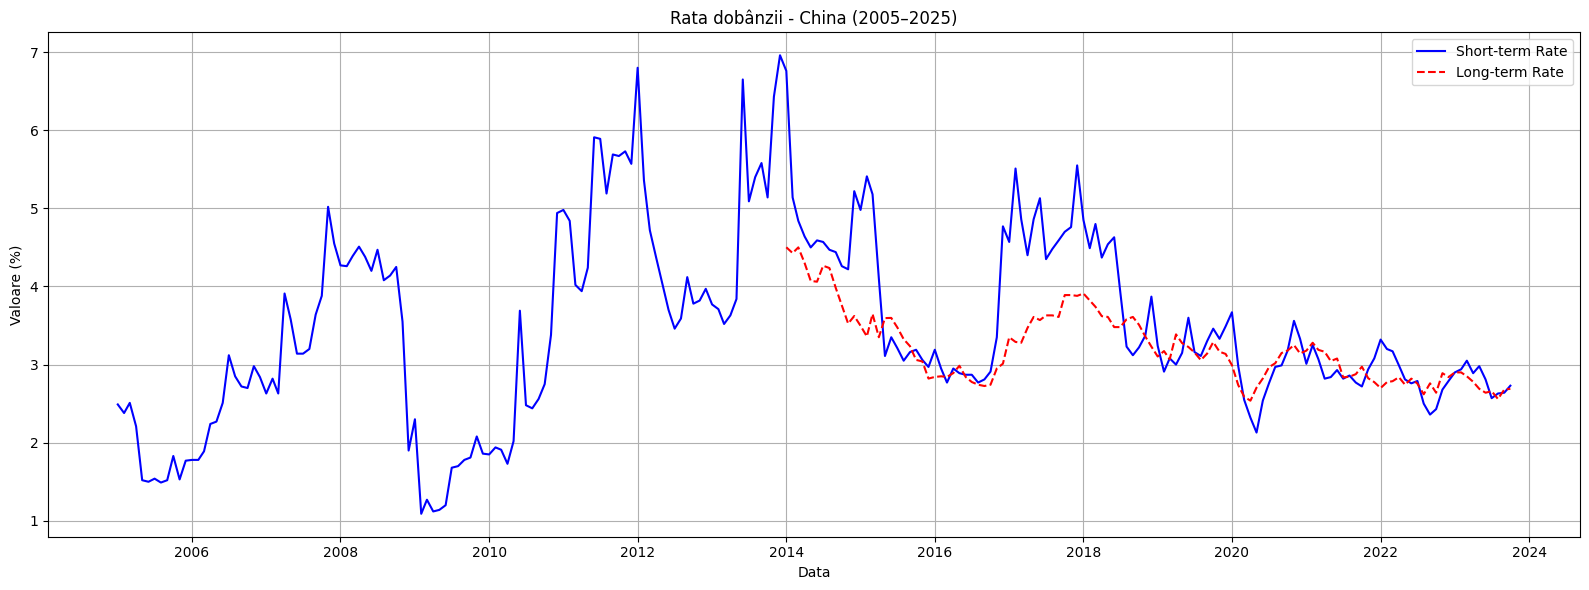

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Dicționar: țară -> [coloană short, coloană long]
tari = {
    'United States': ['United States - Short Term', 'United States - Long Term'],
    'Euro area': ['Euro area - Short Term', 'Euro area - Long Term'],
    'China': ['China - Short Term', 'China - Long Term']
}

# Plot pentru fiecare țară
for tara, (short_col, long_col) in tari.items():
    plt.figure(figsize=(16, 6))

    if short_col in Interest_Rates.columns:
        plt.plot(Interest_Rates.index, Interest_Rates[short_col], label='Short-term Rate', color='blue')
    if long_col in Interest_Rates.columns:
        plt.plot(Interest_Rates.index, Interest_Rates[long_col], label='Long-term Rate', linestyle='--', color='red')

    plt.title(f'Rata dobânzii - {tara} (2005–2025)')
    plt.ylabel('Valoare (%)')
    plt.xlabel('Data')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# **RATA SOMAJULUI**

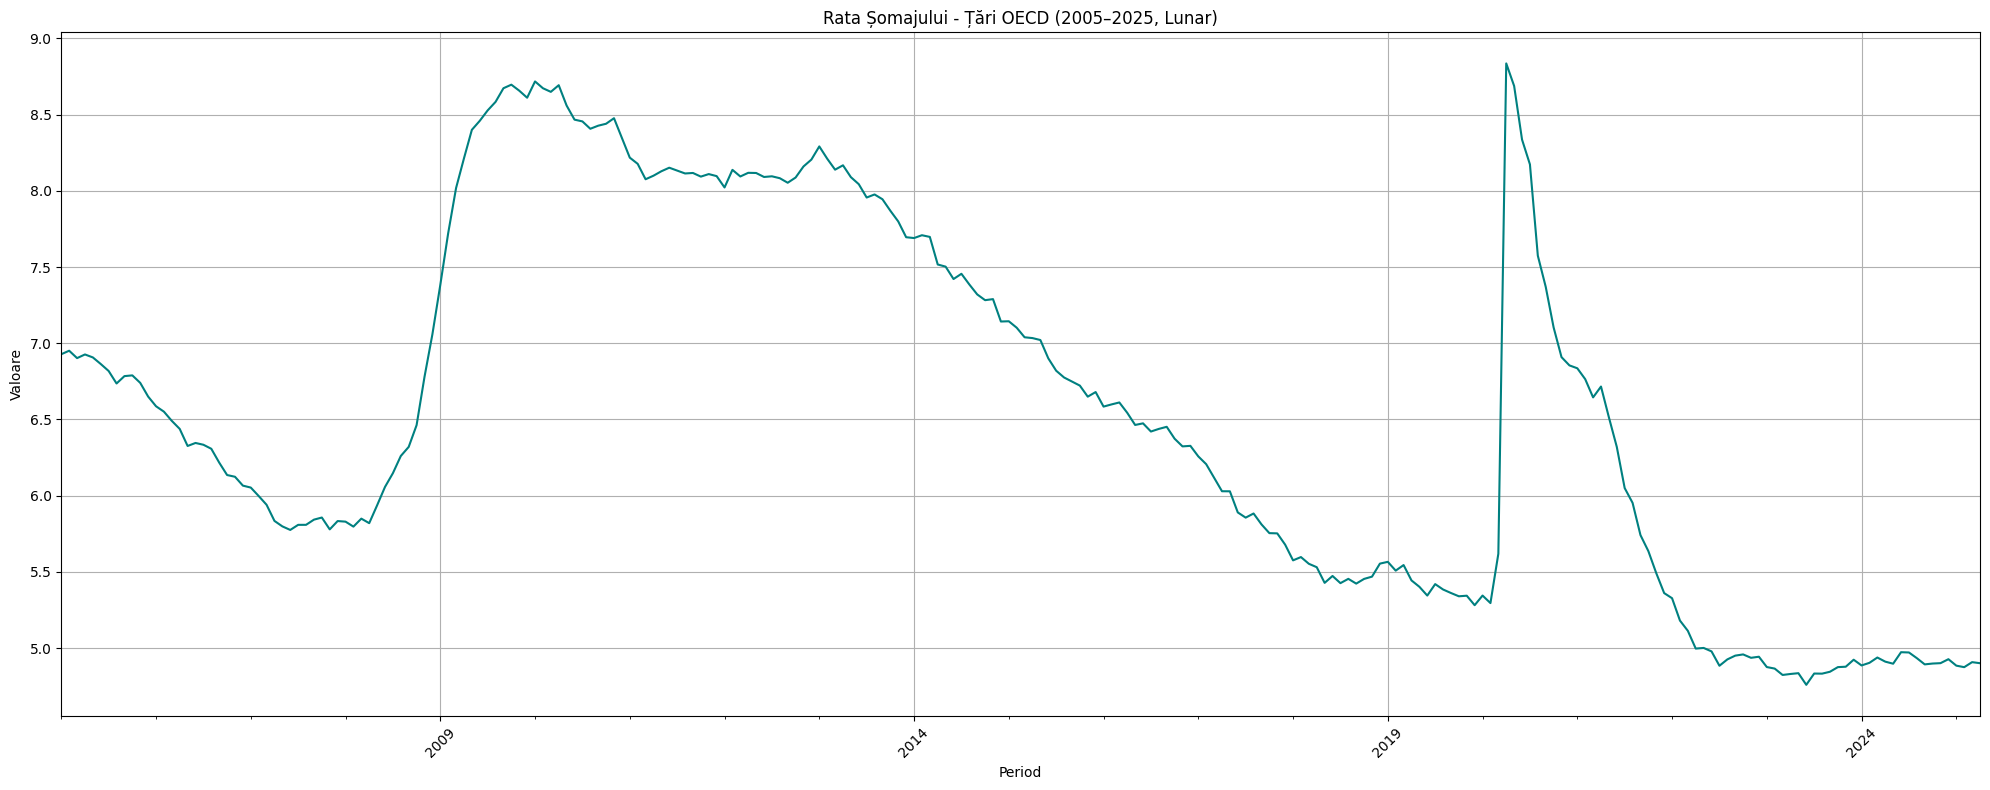

In [ ]:
#Rata Somajului
fig, ax = plt.subplots(figsize=(20, 8))
Unemployment_rate.plot(ax=ax, title='Rata Șomajului - Țări OECD (2005–2025, Lunar)', color='teal', legend=False)
ax.set_ylabel("Valoare")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
plt.show()

In [ ]:
calculeaza_momente(Unemployment_rate)

,N,Mean,Mediana,Std Deviation,Variance,Skewness,Kurtosis,Coeff Variation,Min,Max,25%,50%,75%,90%,95%,99%
0,244,6.576864,6.457546,1.219534,1.487262,0.21309,-1.23268,0.185428,4.759399,8.836058,5.525435,6.457546,7.741326,8.216488,8.520069,8.695014


# **PURCHASING MANAGER'S INDEX**

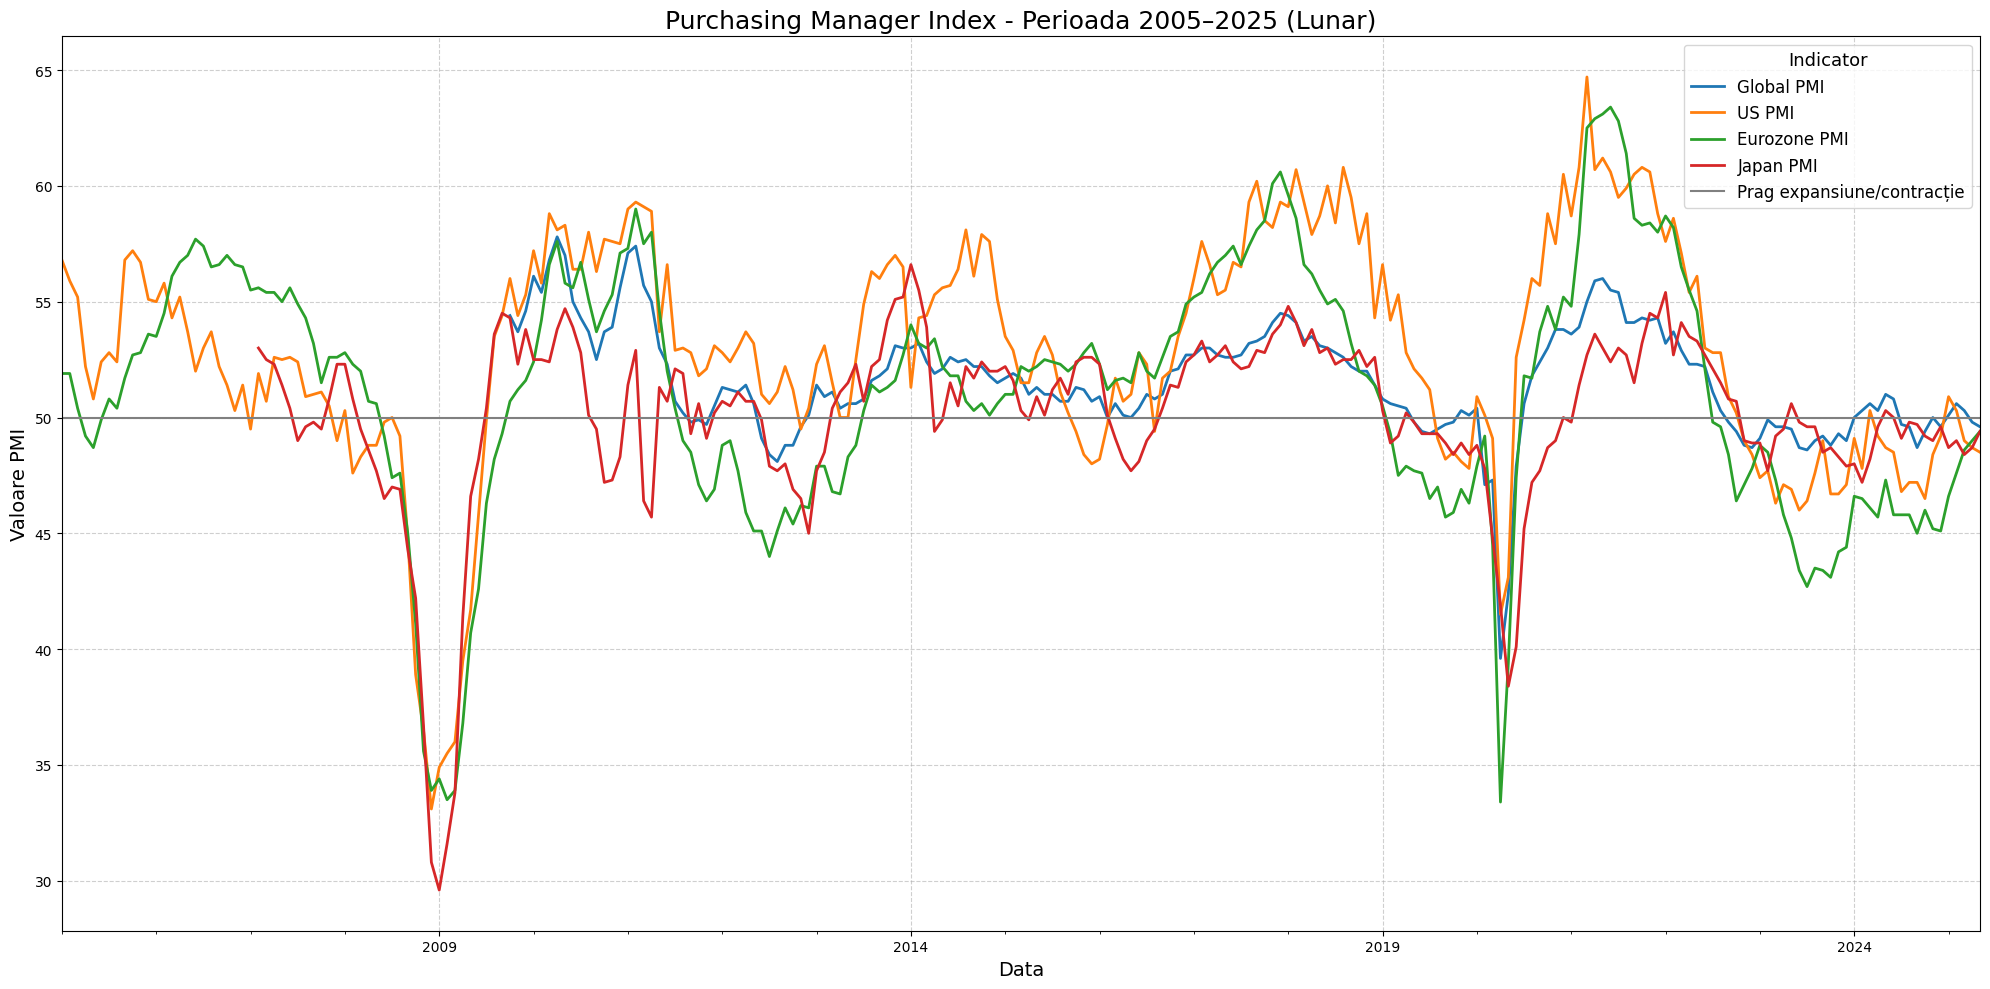

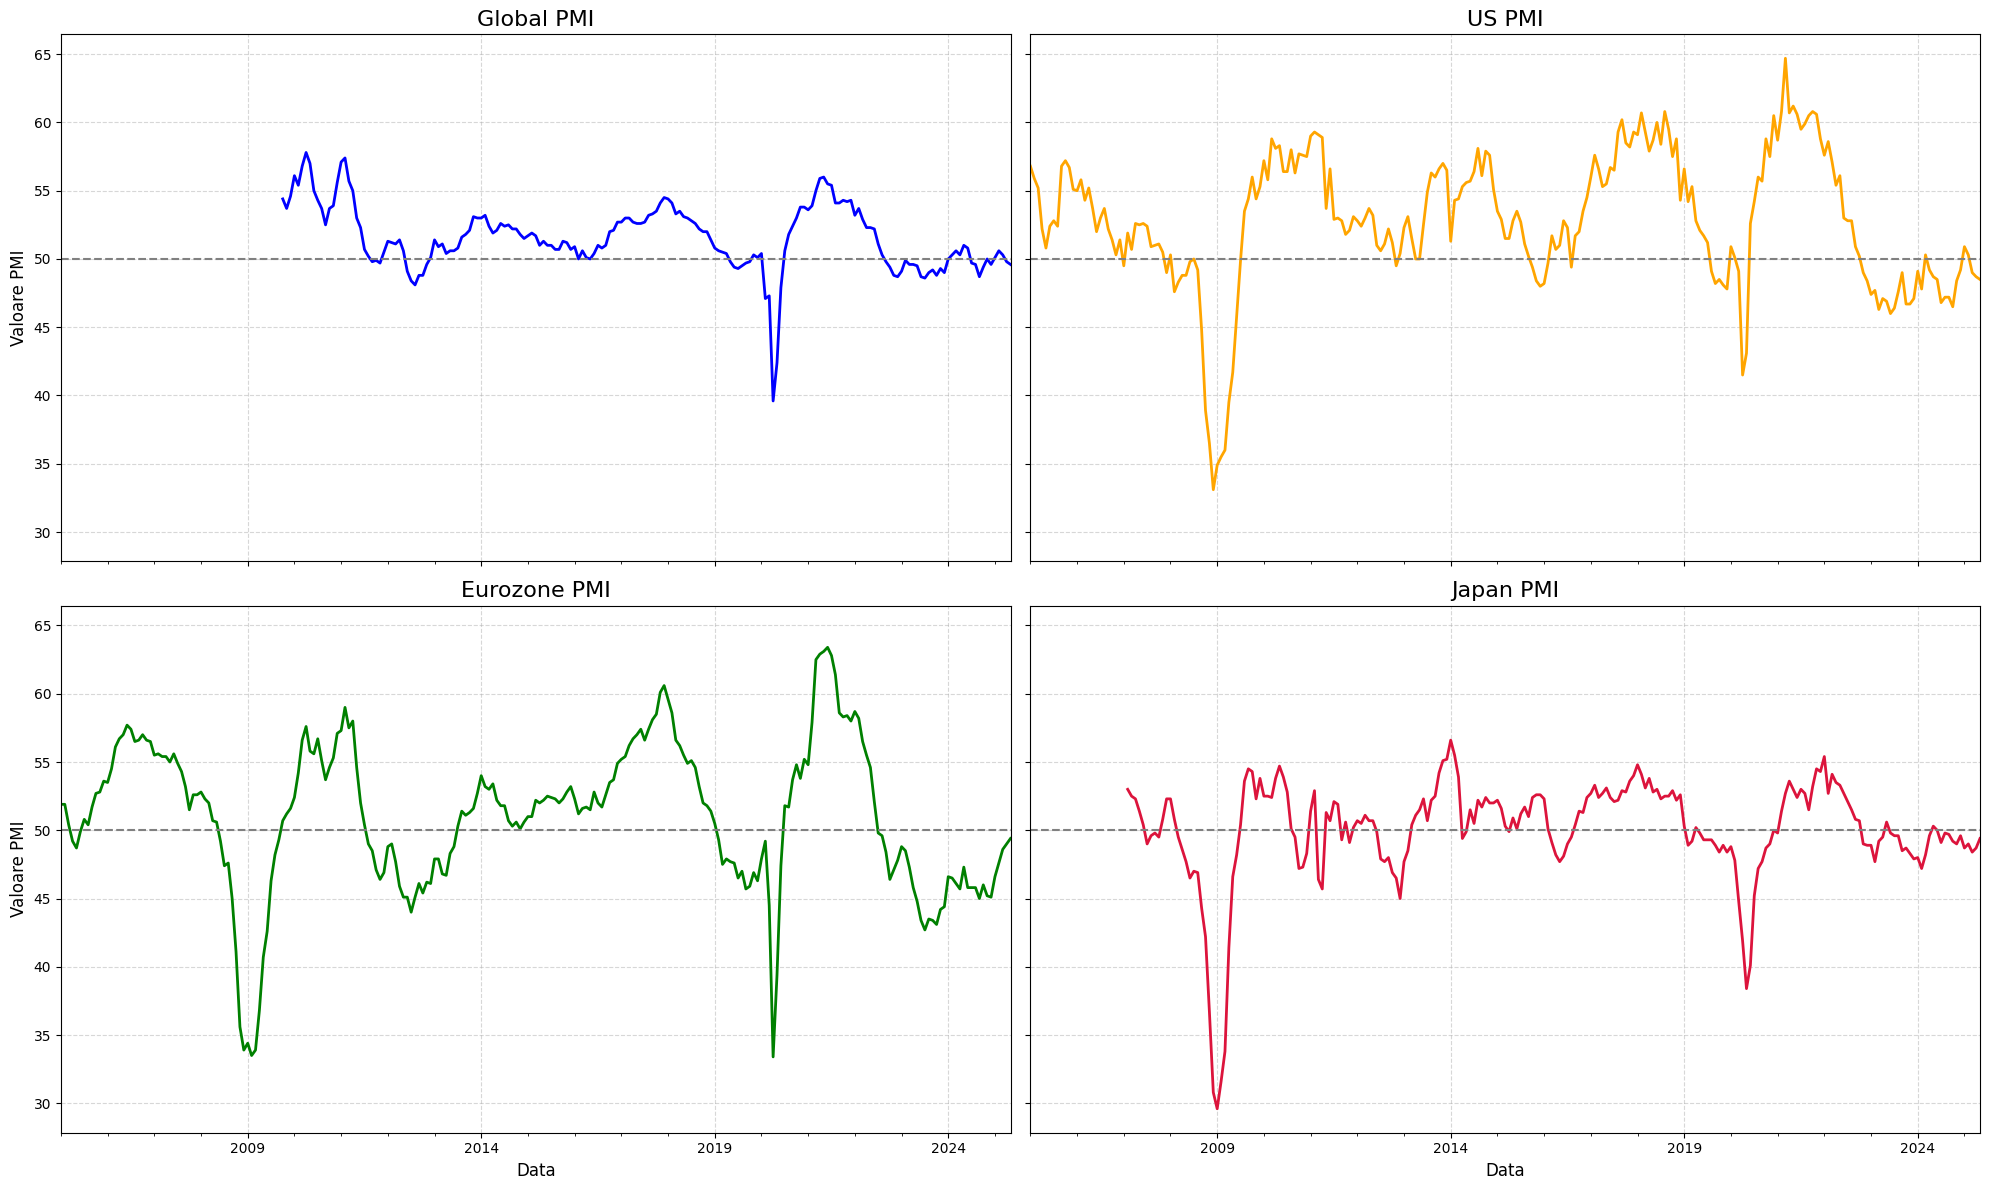

In [ ]:
import matplotlib.pyplot as plt

# Grafic principal comparativ
plt.figure(figsize=(20, 10))
ax = plt.gca()
PMI['Global PMI'].plot(ax=ax, linewidth=2, label='Global PMI')
PMI['US PMI'].plot(ax=ax, linewidth=2, linestyle='-', label='US PMI')
PMI['Eurozone PMI'].plot(ax=ax, linewidth=2, linestyle='-', label='Eurozone PMI')
PMI['Japan PMI'].plot(ax=ax, linewidth=2, linestyle='-', label='Japan PMI')
ax.axhline(y=50, color='gray', linestyle='-', linewidth=1.5, label='Prag expansiune/contracție')
ax.set_title('Purchasing Manager Index - Perioada 2005–2025 (Lunar)', fontsize=18)
ax.set_ylabel("Valoare PMI", fontsize=14)
ax.set_xlabel("Data", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title="Indicator", fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()

# Grafice individuale
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharex=True, sharey=True)

# Setări comune
def plot_single(ax, serie, title, color):
    PMI[serie].plot(ax=ax, color=color, linewidth=2)
    ax.axhline(y=50, color='gray', linestyle='--', linewidth=1.5)
    ax.set_title(f"{title}", fontsize=16)
    ax.set_ylabel("Valoare PMI", fontsize=12)
    ax.set_xlabel("Data", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)

# Ploturi individuale
plot_single(axes[0, 0], 'Global PMI', 'Global PMI', 'blue')
plot_single(axes[0, 1], 'US PMI', 'US PMI', 'orange')
plot_single(axes[1, 0], 'Eurozone PMI', 'Eurozone PMI', 'green')
plot_single(axes[1, 1], 'Japan PMI', 'Japan PMI', 'crimson')

plt.tight_layout()
plt.show()


In [ ]:
PMI.describe()

,Global PMI,US PMI,Eurozone PMI,Japan PMI
count,188.000000,245.000000,245.000000,220.000000
mean,51.593617,52.772245,51.085714,50.052273
std,2.384881,5.026704,5.435365,3.835349
min,39.600000,33.100000,33.400000,29.600000
25%,50.075000,49.900000,47.500000,48.900000
50%,51.300000,52.800000,51.700000,50.450000
75%,53.000000,56.500000,55.000000,52.400000
max,57.800000,64.700000,63.400000,56.600000


# **Broad Money**

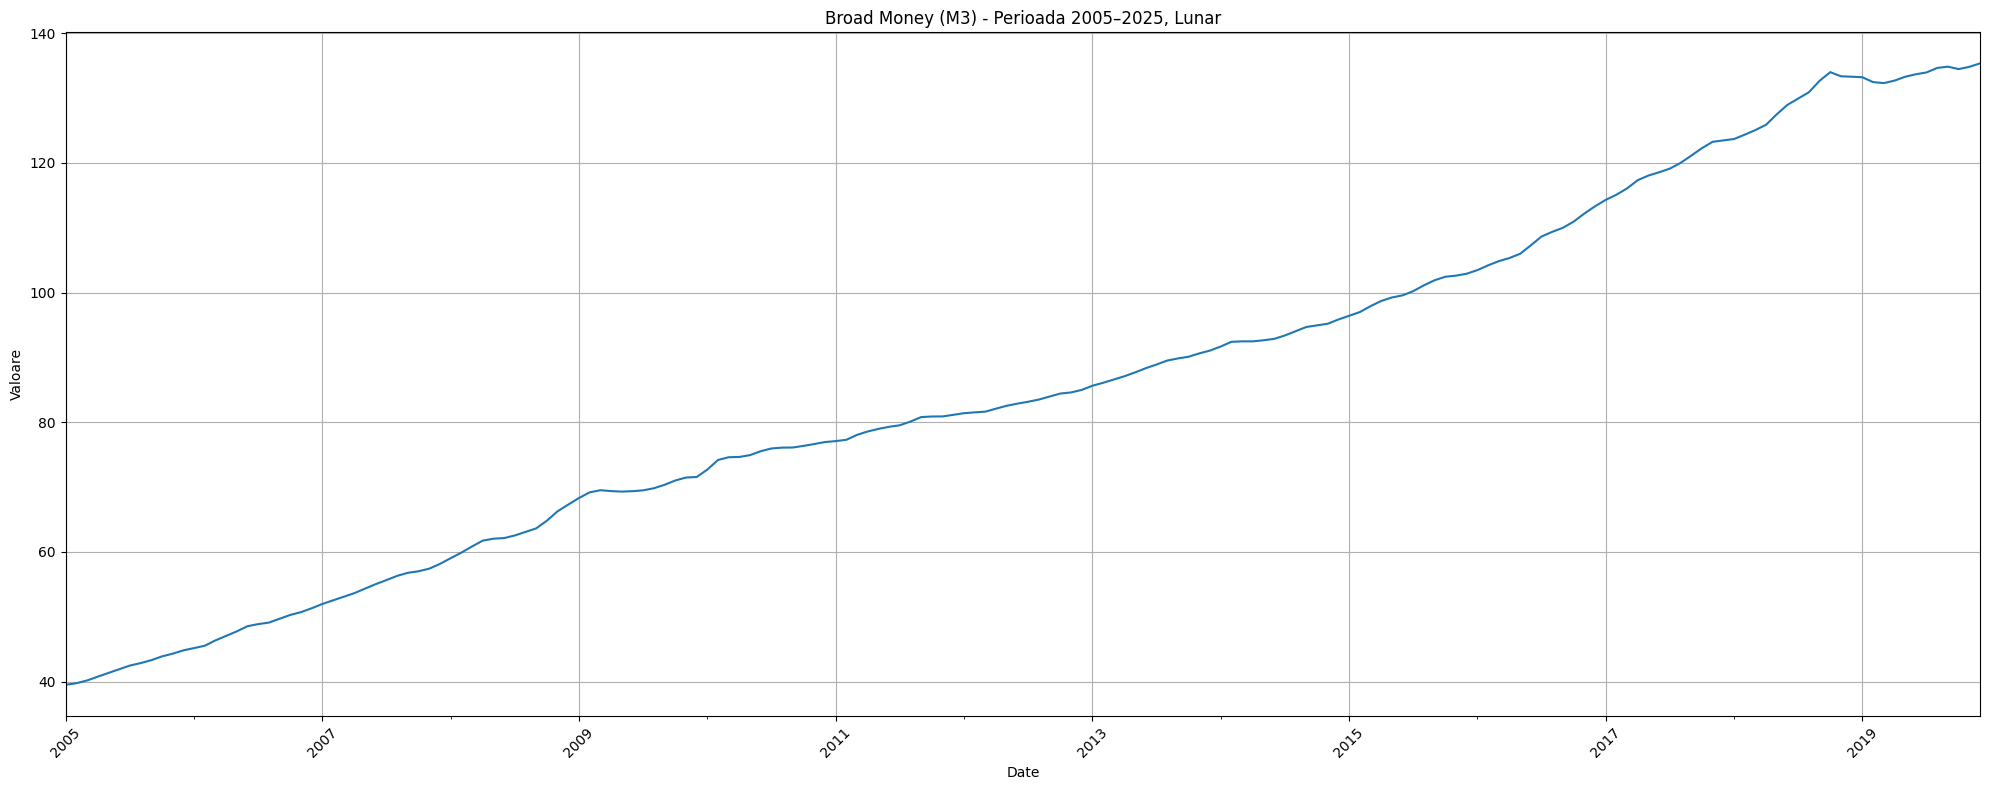

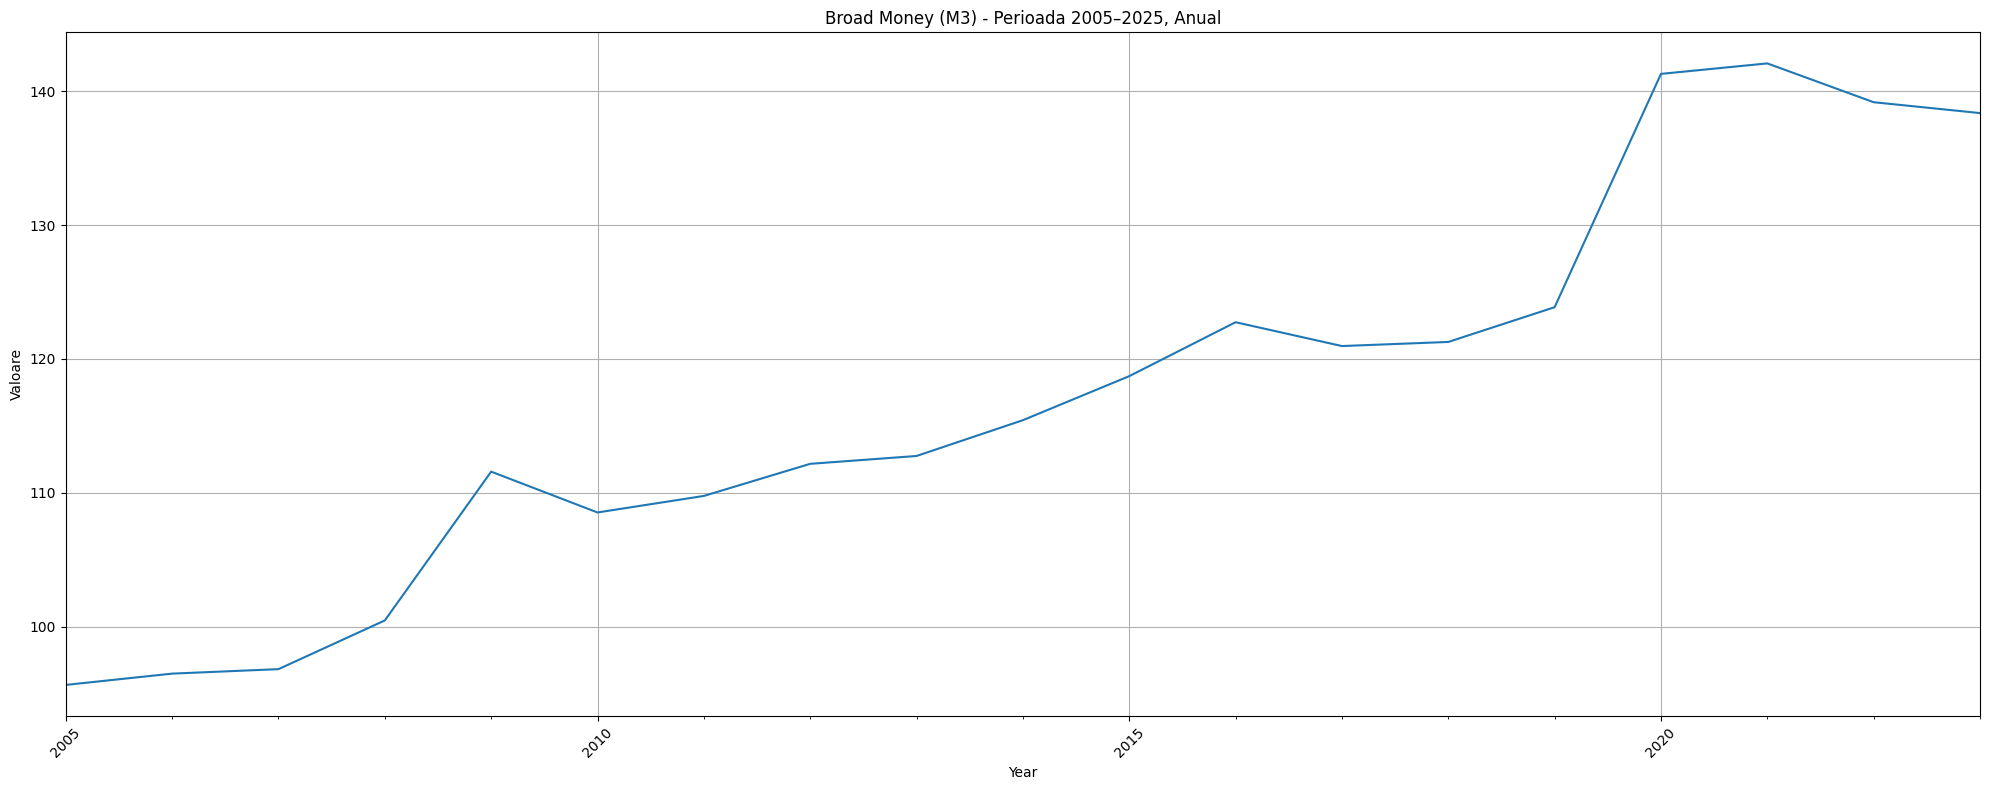

In [ ]:
#Broad money

#Monthly
fig, ax = plt.subplots(figsize=(20, 8))
M3_Monthly.plot(ax=ax, title='Broad Money (M3) - Perioada 2005–2025, Lunar', legend=False)
ax.set_ylabel("Valoare")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
plt.show()


#Yearly
fig, ax = plt.subplots(figsize=(20, 8))
M3_Yearly.plot(ax=ax, title='Broad Money (M3) - Perioada 2005–2025, Anual', legend=False)
ax.set_ylabel("Valoare")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
plt.show()

In [ ]:
calculeaza_momente(M3_Yearly)

,N,Mean,Mediana,Std Deviation,Variance,Skewness,Kurtosis,Coeff Variation,Min,Max,25%,50%,75%,90%,95%,99%
0,19,117.269692,115.425453,14.969467,224.084933,0.290923,-0.774744,0.12765,95.65894,142.065924,109.15239,115.425453,123.301106,139.591107,141.361848,141.925109


In [ ]:
calculeaza_momente(M3_Monthly)

,N,Mean,Mediana,Std Deviation,Variance,Skewness,Kurtosis,Coeff Variation,Min,Max,25%,50%,75%,90%,95%,99%
0,180,85.876728,83.02369,27.52033,757.368572,0.195341,-0.932384,0.320463,39.51634,135.3391,64.53355,83.02369,104.96645,129.05076,133.292105,134.815227


# **INDICI RECESIUNE**

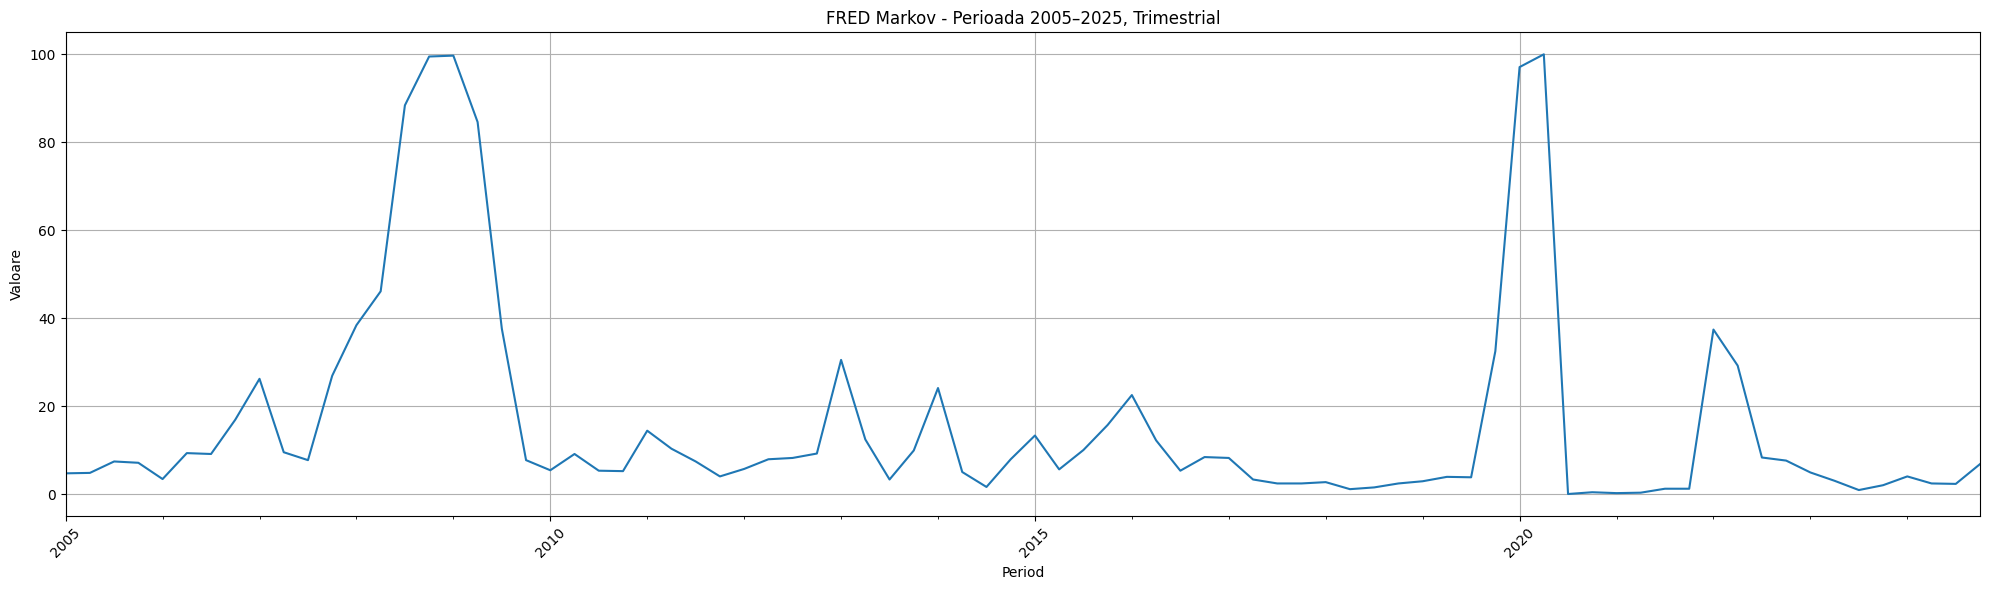

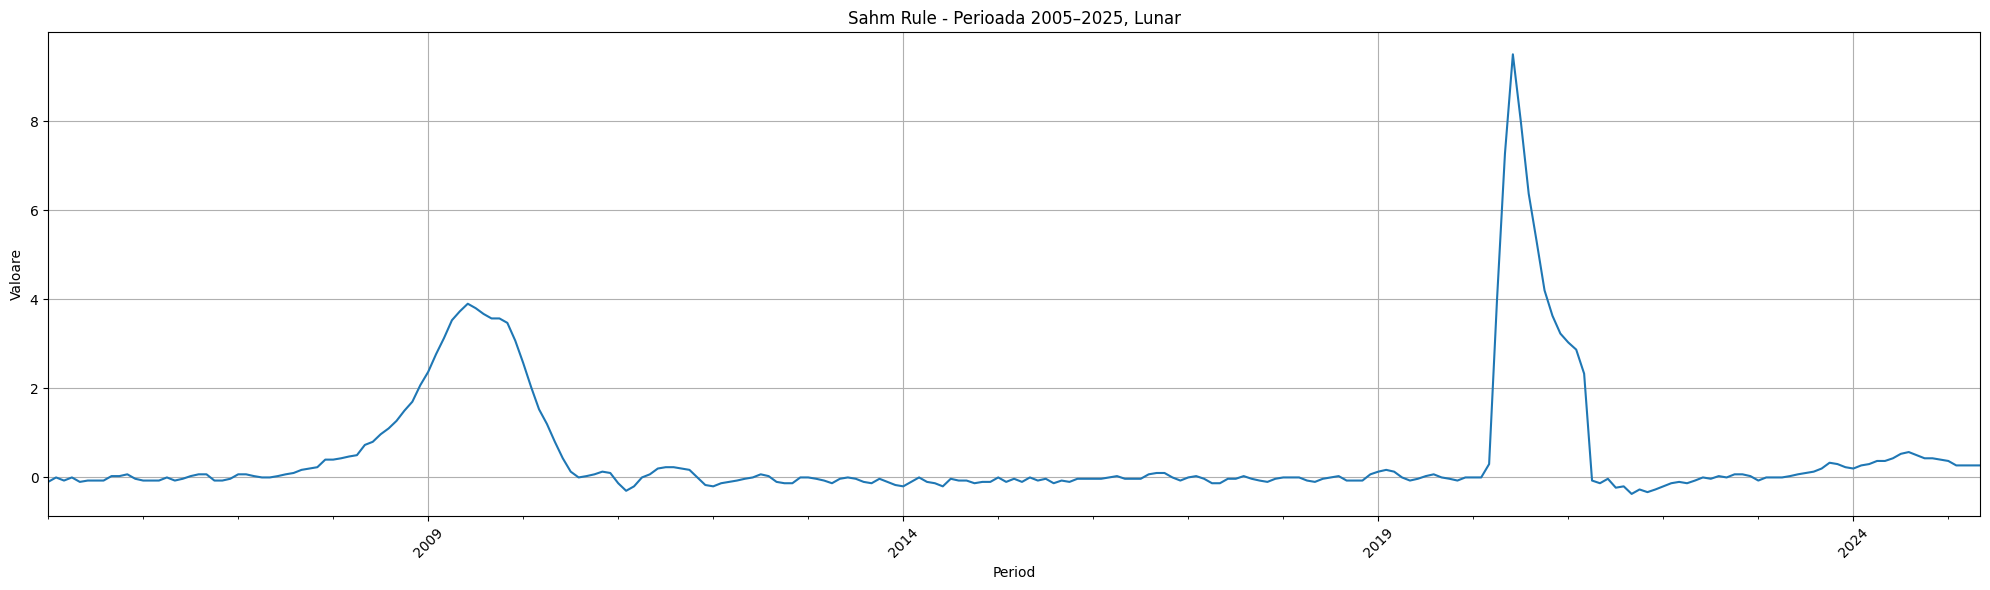

In [ ]:
#Indicatori recesiune

#FRED - Trimestrial
fig, ax = plt.subplots(figsize=(20, 6))
FRED_Markov.plot(ax=ax, title='FRED Markov - Perioada 2005–2025, Trimestrial', legend=False)
ax.set_ylabel("Valoare")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
plt.show()

#Sahm Rule
fig, ax = plt.subplots(figsize=(20, 6))
Sahm_Rule.plot(ax=ax, title='Sahm Rule - Perioada 2005–2025, Lunar', legend=False)
ax.set_ylabel("Valoare")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
plt.show()

# **Heat Map de corelare**

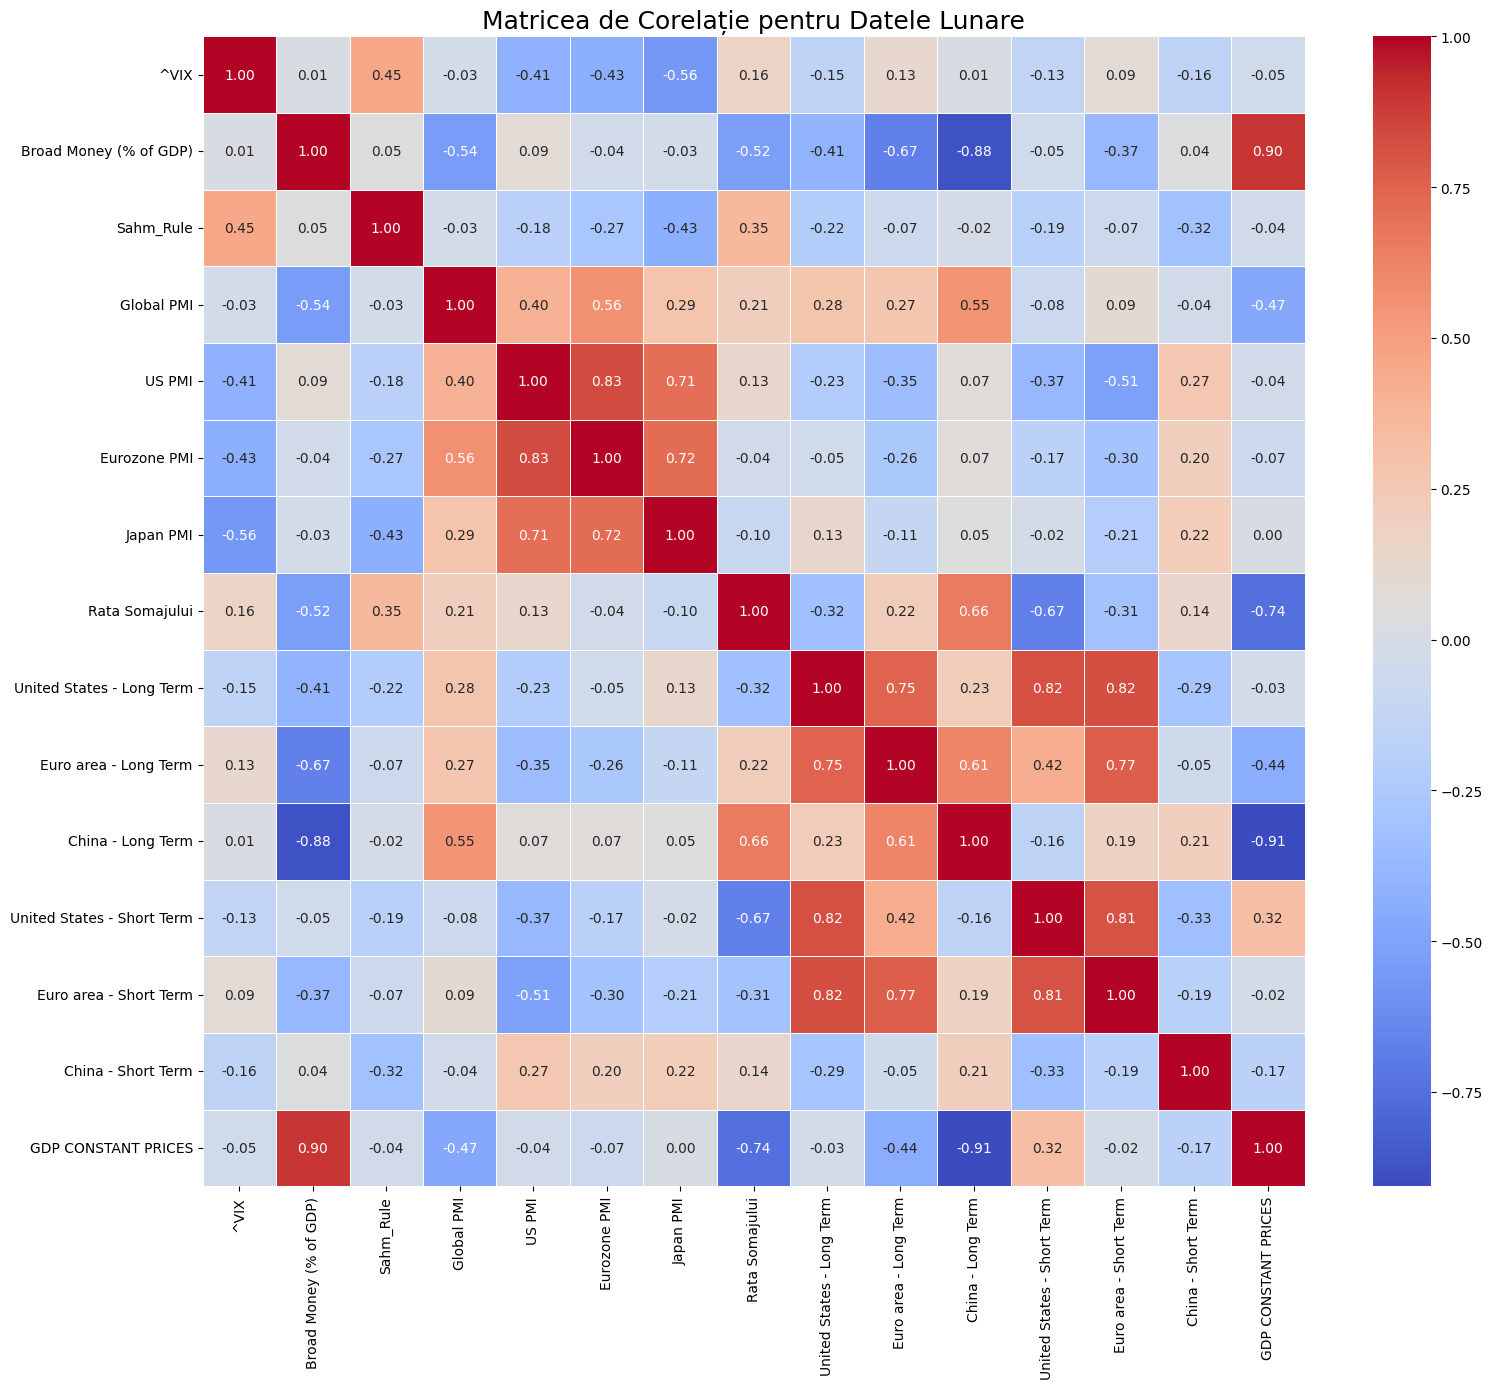


Top 10 corelații pozitive:
Broad Money (% of GDP)      GDP CONSTANT PRICES           0.898530
US PMI                      Eurozone PMI                  0.831404
United States - Long Term   Euro area - Short Term        0.824332
                            United States - Short Term    0.816355
United States - Short Term  Euro area - Short Term        0.809049
Euro area - Long Term       Euro area - Short Term        0.767581
United States - Long Term   Euro area - Long Term         0.750071
Eurozone PMI                Japan PMI                     0.715224
US PMI                      Japan PMI                     0.706174
Rata Somajului              China - Long Term             0.655397
dtype: float64

Top 10 corelații negative:
China - Long Term       GDP CONSTANT PRICES          -0.906684
Broad Money (% of GDP)  China - Long Term            -0.883873
Rata Somajului          GDP CONSTANT PRICES          -0.743886
                        United States - Short Term   -0.674967
Broad M

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Calculăm matricea de corelație ===
correlation_matrix = data_monthly.corr()

# === 2. Vizualizăm heatmap-ul ===
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Matricea de Corelație pentru Datele Lunare", fontsize=18)
plt.tight_layout()
plt.show()

# === 3. Corelații extrase în formă de listă, fără duplicări și auto-corelații ===
cor_pairs = correlation_matrix.unstack()
cor_pairs = cor_pairs[cor_pairs.index.get_level_values(0) != cor_pairs.index.get_level_values(1)]
cor_pairs = cor_pairs.drop_duplicates().sort_values()

# === 4. Top corelații pozitive și negative ===
top_positive = cor_pairs.tail(10)[::-1]  # cele mai mari corelații pozitive
top_negative = cor_pairs.head(10)        # cele mai mici (negative) corelații

print("\nTop 10 corelații pozitive:")
print(top_positive)

print("\nTop 10 corelații negative:")
print(top_negative)

In [ ]:
import statsmodels.api as sm

# === 1. Definirea variabilei dependente și a predictorilor ===
y_std = data_monthly_std['GDP CONSTANT PRICES']
X_std = data_monthly_std.drop(columns=['GDP CONSTANT PRICES'])

# === 2. Adăugăm o constantă (intercept) ===
X_std_const = sm.add_constant(X_std)

# === 3. Modelul de regresie ===
model_std = sm.OLS(y_std, X_std_const)
results_std = model_std.fit()

# === 4. Rezumatul modelului ===
print(results_std.summary())


                             OLS Regression Results                            
Dep. Variable:     GDP CONSTANT PRICES   R-squared:                       0.976
Model:                             OLS   Adj. R-squared:                  0.975
Method:                  Least Squares   F-statistic:                     676.9
Date:                 Wed, 11 Jun 2025   Prob (F-statistic):          2.68e-179
Time:                         18:17:38   Log-Likelihood:                 110.68
No. Observations:                  247   AIC:                            -191.4
Df Residuals:                      232   BIC:                            -138.7
Df Model:                           14                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const     

# **Cauzalitate Granger pe corelatii mari**

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

def make_stationary(df, alpha=0.05, max_diff=2, verbose=False):
    """
    Transformă serii într-un DataFrame staționar (prin diferențiere dacă p > alpha).
    Returnează: df_staționarizat, dict cu ordinele de diferențiere
    """
    df_stationary = pd.DataFrame(index=df.index)
    diffs = {}

    for col in df.columns:
        series = df[col].dropna()
        order = 0
        while order <= max_diff:
            p_value = adfuller(series.dropna(), autolag='AIC')[1]
            if p_value < alpha:
                break
            series = series.diff().dropna()
            order += 1

        if verbose:
            print(f"{col}: adf p={p_value:.4f}, diff_order={order}")

        diffs[col] = order
        df_stationary[col] = df[col].diff(order) if order > 0 else df[col]

    return df_stationary.dropna(), diffs

In [ ]:
def granger_test_pair(df, x, y, maxlag=12, alpha=0.05):
    """
    Aplică testul Granger bidirecțional între x și y. Returnează p-urile și direcția semnificativă.
    """
    temp_df = df[[x, y]].dropna()
    if temp_df.shape[0] <= maxlag:
        return []

    try:
        result1 = grangercausalitytests(temp_df[[y, x]], maxlag=maxlag, verbose=False)
        pval1 = result1[maxlag][0]['ssr_ftest'][1]
    except:
        pval1 = np.nan

    try:
        result2 = grangercausalitytests(temp_df[[x, y]], maxlag=maxlag, verbose=False)
        pval2 = result2[maxlag][0]['ssr_ftest'][1]
    except:
        pval2 = np.nan

    out = []
    if pd.notna(pval1) and pval1 < alpha:
        out.append({'from': x, 'to': y, 'p_value': pval1})
    if pd.notna(pval2) and pval2 < alpha:
        out.append({'from': y, 'to': x, 'p_value': pval2})

    return out

In [ ]:
# 1. Standardizăm și eliminăm variabile complet NaN
df = data_monthly.dropna(axis=1, how='all')
df_std = (df - df.mean()) / df.std()

# 2. Staționarizăm tot setul
df_stat, diff_orders = make_stationary(df_std, alpha=0.05, verbose=True)

# 3. Corelații pe date staționare
cor_matrix = df_stat.corr()
cor_pairs = cor_matrix.unstack().drop_duplicates().sort_values(ascending=False)
cor_pairs = cor_pairs[cor_pairs.index.get_level_values(0) != cor_pairs.index.get_level_values(1)]
sig_cor_pairs = cor_pairs[(cor_pairs > 0.5) | (cor_pairs < -0.5)]

# 4. Aplicăm Granger pe perechi semnificative
granger_edges = []
for (var1, var2), rho in sig_cor_pairs.items():
    results = granger_test_pair(df_stat, var1, var2, maxlag=12, alpha=0.1)
    for res in results:
        res['correlation'] = rho
        granger_edges.append(res)

df_granger = pd.DataFrame(granger_edges)
df_granger_sig = df_granger[df_granger['p_value'] < 0.1].copy()

# Clasificăm culoarea în funcție de p
def pval_color(p):
    if p < 0.01:
        return 'blue'
    elif p < 0.05:
        return 'green'
    else:
        return 'orange'

df_granger_sig['color'] = df_granger_sig['p_value'].apply(pval_color)
df_granger_sig['label'] = df_granger_sig['p_value'].apply(lambda p: f"p={p:.3f}")

^VIX: adf p=0.0000, diff_order=0
Broad Money (% of GDP): adf p=0.0000, diff_order=2
Sahm_Rule: adf p=0.0081, diff_order=0
Global PMI: adf p=0.0046, diff_order=0
US PMI: adf p=0.0140, diff_order=0
Eurozone PMI: adf p=0.0001, diff_order=0
Japan PMI: adf p=0.0001, diff_order=0
Rata Somajului: adf p=0.0000, diff_order=1
United States - Long Term: adf p=0.0000, diff_order=1
Euro area - Long Term: adf p=0.0000, diff_order=1
China - Long Term: adf p=0.0000, diff_order=1
United States - Short Term: adf p=0.0344, diff_order=1
Euro area - Short Term: adf p=0.0022, diff_order=1
China - Short Term: adf p=0.0116, diff_order=0
GDP CONSTANT PRICES: adf p=0.0000, diff_order=1


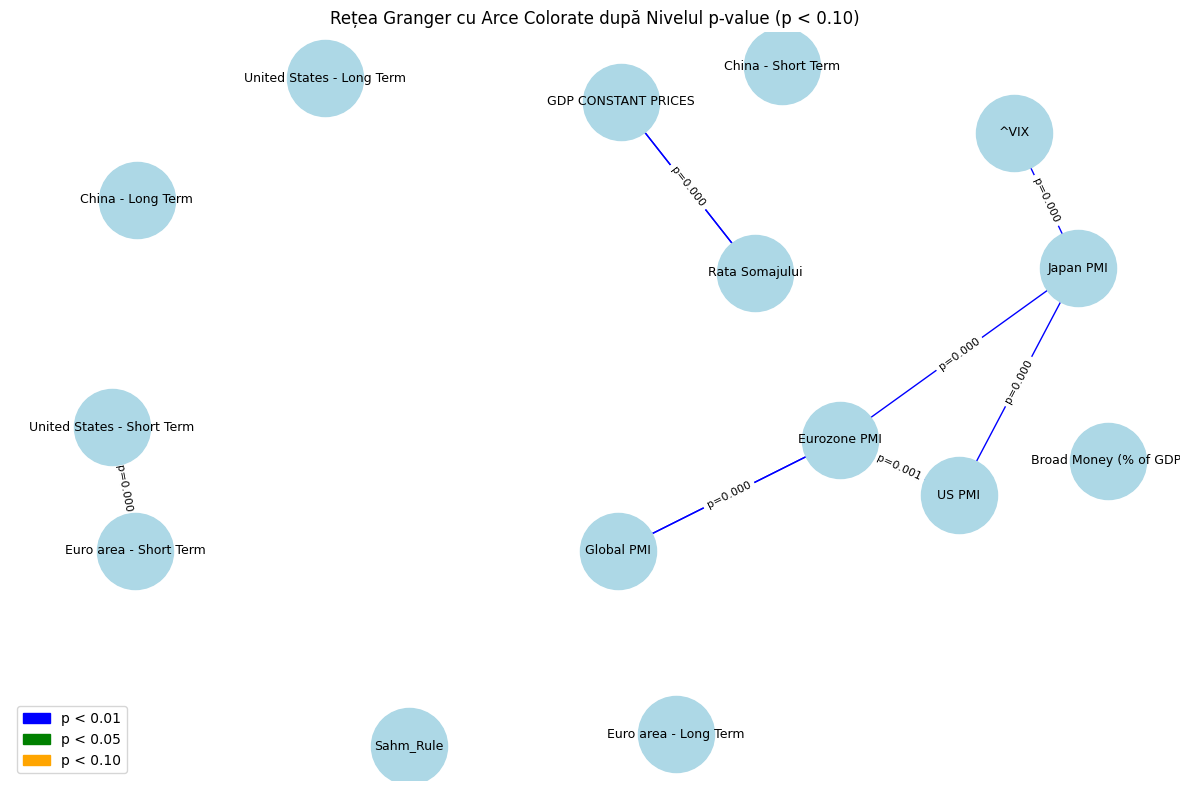

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Graful direcționat
G = nx.DiGraph()
for col in df_stat.columns:
    G.add_node(col)

# Adăugăm doar relațiile cu p < 0.10
for _, row in df_granger_sig.iterrows():
    G.add_edge(row['from'], row['to'],
               weight=1 - row['p_value'],
               label=row['label'],
               color=row['color'])

# Layout
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1, seed = 8)

# Noduri
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue')

# Arce colorate
edge_colors = [G[u][v]['color'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=True, arrowsize=15)

# Etichete noduri
nx.draw_networkx_labels(G, pos, font_size=9)

# Etichete p-value
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Legenda culori
import matplotlib.patches as mpatches
legend_patches = [
    mpatches.Patch(color='blue', label='p < 0.01'),
    mpatches.Patch(color='green', label='p < 0.05'),
    mpatches.Patch(color='orange', label='p < 0.10')
]

plt.legend(handles=legend_patches, loc='lower left')
plt.title("Rețea Granger cu Arce Colorate după Nivelul p-value (p < 0.10)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
print("\n✅ Perechi semnificative Granger:")
print(df_granger.sort_values(by='p_value'))


✅ Perechi semnificative Granger:
                         from                          to       p_value  \
8              Rata Somajului         GDP CONSTANT PRICES  3.793811e-41   
9         GDP CONSTANT PRICES              Rata Somajului  7.148900e-20   
6                Eurozone PMI                  Global PMI  2.541536e-08   
7                        ^VIX                   Japan PMI  1.744641e-06   
4      Euro area - Short Term  United States - Short Term  7.853499e-05   
2                      US PMI                   Japan PMI  1.099990e-04   
3  United States - Short Term      Euro area - Short Term  1.679861e-04   
1                Eurozone PMI                   Japan PMI  3.304718e-04   
5                  Global PMI                Eurozone PMI  4.101099e-04   
0                Eurozone PMI                      US PMI  5.538513e-04   

   correlation  
8    -0.563907  
9    -0.563907  
6     0.563847  
7    -0.556693  
4     0.619415  
2     0.704958  
3     0.619415  
1   